## 1. AGNES 중분류

In [15]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

# 덴드로그램 시각화 (2차원일 때만)
def plot_dendrogram(data, method="average", metric="euclidean", title="Dendrogram"):
    linked = linkage(data, method=method, metric=metric)
    plt.figure(figsize=(12, 6))
    dendrogram(linked)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

# 최적 임계값과 실루엣 점수 찾기
def find_optimal_threshold(data, low=0.5, high=2.0, max_iter=1000):
    best_threshold = None
    best_score = -1
    best_labels = None
    best_n_clusters = None
    thresholds = []
    silhouette_scores = []
    n_clusters_list = []
    iter_count = 0
    
    print("▶ Finding the optimal distance_threshold using binary search...\n")

    while high - low > 0.001 and iter_count < max_iter:
        iter_count += 1
        mid = (low + high) / 2
        agnes = AgglomerativeClustering(n_clusters=None, metric="euclidean", linkage="average", distance_threshold=mid)
        labels = agnes.fit_predict(data)
        n_clusters = len(np.unique(labels))

        if n_clusters > 1:
            silhouette = silhouette_score(data, labels, metric="euclidean")
            thresholds.append(mid)
            silhouette_scores.append(silhouette)
            n_clusters_list.append(n_clusters)
            print(f"Distance Threshold: {mid:.3f}, Clusters: {n_clusters}, Silhouette Score: {silhouette:.4f}")

            if silhouette > best_score:
                best_score = silhouette
                best_threshold = mid
                best_labels = labels
                best_n_clusters = n_clusters

            if silhouette >= best_score:
                low = mid
            else:
                high = mid
    # 그래프 출력
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, silhouette_scores, marker='o', linestyle='-', color='blue')
    plt.title("Silhouette Score by Distance Threshold")
    plt.xlabel("Distance Threshold")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

    print(f"\n▶ Optimal Distance Threshold Found!")
    print(f"Best distance_threshold: {best_threshold:.3f}, Best Clusters: {best_n_clusters}, Best Silhouette Score: {best_score:.4f}")
    return best_threshold, best_labels, best_score, best_n_clusters

# 클러스터 시각화 (2차원일 때만)
def plot_silhouette(data, labels, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar(label="Cluster Label")
    plt.show()

# AGNES 클러스터링 및 통합 처리
def process_agnes_embedding(name, data, metadata_df=None):
    print(f"Processing: {name}")

    # 1. 덴드로그램 (2D일 때만)
    if data.shape[1] == 2:
        print("\n1. Dendrogram Visualization")
        plot_dendrogram(data, method="average", metric="euclidean", title=f"Dendrogram ({name})")
    else:
        print("\n1. Dendrogram skipped (not 2D)")

    # 2. 최적 threshold 탐색
    print("\n2. Finding the optimal distance_threshold...")
    best_threshold, best_labels, best_score, best_n_clusters = find_optimal_threshold(data)

    # 3. 최종 덴드로그램 (2D일 때만)
    if data.shape[1] == 2:
        print("\n3. Dendrogram with Optimal Threshold")
        linked = linkage(data, method="average", metric="euclidean")
        plt.figure(figsize=(12, 6))
        dendrogram(linked, color_threshold=best_threshold)
        plt.axhline(y=best_threshold, color="r", linestyle="--", label=f"Best threshold = {best_threshold:.3f}")
        plt.title(f"Dendrogram with Optimal Distance Threshold ({name})")
        plt.legend()
        plt.show()

    # 4. 클러스터링 결과 시각화 (2D만)
    if data.shape[1] == 2:
        print("\n4. Final Clustering Result")
        plot_silhouette(data, best_labels, title=f"Final Clustering ({name})")
    else:
        print("\n4. Final Clustering Result skipped (not 2D)")

    # 5. 결과 저장
    df_result = pd.DataFrame(data)
    df_result['Cluster'] = best_labels

    if best_n_clusters > 1:
        silhouette_vals = silhouette_samples(data, best_labels, metric="euclidean")
        df_result['Silhouette'] = silhouette_vals
    else:
        df_result['Silhouette'] = -1

    # 메타데이터 병합
    if metadata_df is not None:
        df_result = pd.concat([metadata_df.reset_index(drop=True), df_result], axis=1)

    # 리턴
    return {
        'name': name,
        'best_threshold': best_threshold,
        'n_clusters': best_n_clusters,
        'silhouette_score': best_score,
        'data': df_result
    }

In [16]:
def agnes_subcluster_for_id(cluster_id, df, embedding_cols):
    cluster_data = df[df['Cluster'] == cluster_id]
    X_cluster = cluster_data[embedding_cols].values

    try:
        _, best_labels, _, _ = find_optimal_threshold(X_cluster)
        return pd.Series(best_labels, index=cluster_data.index)
    except Exception as e:
        print(f"[ERROR] Cluster {cluster_id}: {e}")
        return pd.Series([-1] * len(cluster_data), index=cluster_data.index)

In [17]:
# 이 부분 위 코드 cosine으로 바꿔서 다시 돌려봐야함 (시간이 오래 걸림)

file_path = "./all_origin_hi_clu.csv"
df = pd.read_csv(file_path)

# 필요한 컬럼만 추출
embedding_cols = [str(i) for i in range(64)]
X = df[embedding_cols].values

# 클러스터링 수행에 필요한 패키지 로드
from sklearn.cluster import AgglomerativeClustering

# 기존 BIRCH 클러스터 ID 확인
cluster_ids = df['Cluster'].unique()

# AGNES 결과 저장
agnes_all_results = []

# 각 BIRCH 클러스터별로 AGNES 수행
print("▶ Starting AGNES sub-clustering (parallelized)...\n")
agnes_all_results = Parallel(n_jobs=-1)(
    delayed(agnes_subcluster_for_id)(cid, df, embedding_cols)
    for cid in tqdm(df['Cluster'].unique())
)

# 결과 통합
df['AGNES_Subcluster'] = pd.concat(agnes_all_results).sort_index()

▶ Starting AGNES sub-clustering (parallelized)...



▶ Finding the optimal distance_threshold using binary search...

▶ Finding the optimal distance_threshold using binary search...

▶ Finding the optimal distance_threshold using binary search...

▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 15, Silhouette Score: 0.0866
▶ Finding the optimal distance_threshold using binary search...

▶ Finding the optimal distance_threshold using binary search...

▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 37, Silhouette Score: 0.0824
Distance Threshold: 1.250, Clusters: 23, Silhouette Score: 0.1282
Distance Threshold: 1.250, Clusters: 98, Silhouette Score: 0.0471
Distance Threshold: 1.250, Clusters: 35, Silhouette Score: 0.0223
▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 34, Silhouette Score: 0.0623
Distance Threshold: 1.250, Clusters: 59, Silhouette Score: 0.0515
Distance Threshold

100%|██████████| 23/23 [00:08<00:00,  2.79it/s]

Figure(800x500)

▶ Optimal Distance Threshold Found!
Best distance_threshold: 1.250, Best Clusters: 23, Best Silhouette Score: 0.1282
▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 28, Silhouette Score: 0.0642


Figure(800x500)

▶ Optimal Distance Threshold Found!
Best distance_threshold: 1.250, Best Clusters: 15, Best Silhouette Score: 0.0866
▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 38, Silhouette Score: 0.0651
Figure(800x500)

▶ Optimal Distance Threshold Found!
Best distance_threshold: 1.250, Best Clusters: 16, Best Silhouette Score: 0.0705
▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 31, Silhouette Score: 0.0201
Figure(800x500)

▶ Optimal Distance Threshold Found!
Best distance_threshold: 1.250, Best Clusters: 28, Best Silhouette Score: 0.0642
▶ Finding the optimal distance_threshold using binary search...

Distance Threshold: 1.250, Clusters: 10, Silhouette Score: 0.0531
Figure(800x500)

▶ Optimal Distance Threshold Found!
Best distance_threshold: 1.250, Best Clusters: 10, Best Silhouette Score: 0.0531
▶ Finding the optimal distance_threshold using binary search...

Distan

In [18]:
df

ticket_id_hashed                                  generated_summary  \
0              569aa41  The user suggests having the control panel lig...   
1              d71a6d7  The user suggests allowing full integration wi...   
2              04d7c25  The user suggests improving local control over...   
3              b6452d1  The user suggests enabling remote start withou...   
4              d25d98b  The user suggests providing a way to correct t...   
...                ...                                                ...   
24318          e0d440d  The user suggests changing the connection part...   
24319          45e8080  The user suggests a feature that allows settin...   
24320          864eeff  The user suggests adding an option for up, dow...   
24321          6f042cb  The user suggests saving the wind direction se...   
24322          2ce21ff  The user suggests enabling the ability to set ...   

              0         1         2         3         4         5         6  \
0      0.075767  0.079022  0.016558 -0.162251 -0.069939  0.176784  0.344817   
1     -0.052784  0.040736 -0.131763  0.073862  0.318433 -0.123994 -0.159574   
2     -0.028329  0.013609 -0.059702  0.057278  0.343442 -0.005791 -0.218238   
3     -0.141433 -0.018786  0.016334  0.223997 -0.112966  0.064390 -0.218879   
4     -0.238858  0.078645 -0.262218  0.181303 -0.024056 -0.108034 -0.032344   
...         ...       ...       ...       ...       ...       ...       ...   
24318 -0.024508 -0.128419 -0.170698 -0.195582  0.054395  0.188260 -0.028575   
24319 -0.129325  0.037916 -0.320286  0.107807 -0.081001  0.065715  0.450952   
24320 -0.219595 -0.075191  0.036713 -0.190824 -0.254214  0.116395  0.048776   
24321  0.015032  0.064386 -0.119413 -0.054165 -0.056012  0.143908 -0.008847   
24322 -0.153779 -0.082016 -0.118203 -0.002988  0.111144  0.223693  0.318352   

              7  ...        57        58        59        60        61  \
0      0.145883  ... -0.064810  0.027450 -0.143102 -0.197554 -0.010960   
1     -0.052375  ... -0.053453  0.184811  0.100419 -0.277661  0.392118   
2      0.090118  ... -0.127528  0.092318  0.188004 -0.490866  0.327098   
3      0.050858  ... -0.242341  0.029058  0.014906 -0.181656  0.142165   
4      0.006672  ...  0.160867 -0.191842  0.024230 -0.378175  0.068542   
...         ...  ...       ...       ...       ...       ...       ...   
24318 -0.063503  ...  0.280975 -0.165160  0.384893 -0.466052  0.099158   
24319 -0.097956  ... -0.151016 -0.171744  0.095755 -0.314283  0.065789   
24320 -0.096348  ... -0.046288 -0.034956 -0.058602 -0.420390  0.176029   
24321 -0.081922  ...  0.125502 -0.118026 -0.080283 -0.468905  0.182202   
24322 -0.054892  ...  0.055828 -0.111918  0.065502 -0.472674  0.043123   

             62        63  Cluster  Silhouette  AGNES_Subcluster  
0     -0.001367  0.213566        7    0.091018                 1  
1     -0.274975  0.241090        0   -0.008502                27  
2      0.023757  0.108377        0   -0.019235                27  
3     -0.291786 -0.186976        6    0.106826                 5  
4      0.088154  0.020848       12    0.141516                 7  
...         ...       ...      ...         ...               ...  
24318  0.047679 -0.176595       13    0.020911                17  
24319 -0.038813  0.204168       14    0.074073                 2  
24320  0.159094 -0.157889       13    0.066487                17  
24321  0.119406  0.020134       13    0.037834                 4  
24322  0.189785  0.035609       13   -0.020969                20  

[24323 rows x 69 columns]

In [19]:
# Subcluster 칼럼 이름 변경
df.rename(columns={'AGNES_Subcluster': 'Subcluster'}, inplace=True)
df.to_csv('./all_origin_emb_red_clu_mid_2.csv', index=False)

## 2. AGNES 중분류 결과 분석

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. 데이터 불러오기
df = pd.read_csv("./all_origin_emb_red_clu_mid_2.csv")  # AGNES 클러스터링 포함
ref_df = pd.read_csv("./all_origin_emb_red.csv")  # 원본 keyword 포함

# 2. 컬럼 이름 변경
df.rename(columns={
    'Cluster': 'Topcluster',
    'Subcluster': 'Midcluster'
}, inplace=True)

# 3. Midcluster ID 생성
df['Midcluster_ID'] = df['Topcluster'].astype(str) + "_" + df['Midcluster'].astype(str)

# 4. 중심좌표 계산
embedding_cols = [str(i) for i in range(64)]
midcluster_centers = df.groupby("Midcluster_ID")[embedding_cols].mean()

# 5. 유사도 행렬 계산
similarity_matrix = cosine_similarity(midcluster_centers)
similarity_df = pd.DataFrame(similarity_matrix,
                             index=midcluster_centers.index,
                             columns=midcluster_centers.index).reset_index()

# 6. 유사도 melt
similarity_melted = similarity_df.melt(id_vars='Midcluster_ID',
                                       var_name='Compared_Midcluster',
                                       value_name='Cosine_Similarity')

# 7. top 3 유사도 추출
top_similar_expanded = (
    similarity_melted[similarity_melted['Midcluster_ID'] != similarity_melted['Compared_Midcluster']]
    .sort_values(['Midcluster_ID', 'Cosine_Similarity'], ascending=[True, False])
    .groupby('Midcluster_ID')
    .head(3)
    .reset_index(drop=True)
)
top_similar_expanded['Rank'] = top_similar_expanded.groupby('Midcluster_ID').cumcount() + 1
top_similar_pivot = top_similar_expanded.pivot(index='Midcluster_ID', columns='Rank',
                                                values=['Compared_Midcluster', 'Cosine_Similarity'])
top_similar_pivot.columns = [f"Most_Similar_{col[1]}" if col[0] == 'Compared_Midcluster'
                             else f"Similarity_{col[1]}" for col in top_similar_pivot.columns]
top_similar_pivot.reset_index(inplace=True)

# 8. 키워드 컬럼 추출
keyword_col = next((col for col in ref_df.columns if 'keyword' in col.lower()), None)

# 9. 클러스터-미드클러스터 매핑
merged = pd.merge(
    df[['ticket_id_hashed', 'Topcluster', 'Midcluster']],
    ref_df[['ticket_id_hashed', keyword_col]],
    on='ticket_id_hashed',
    how='left'
)

# 10. 키워드 집계
grouped_keywords = (
    merged.groupby(["Topcluster", "Midcluster"])[keyword_col]
    .apply(lambda x: pd.Series(x.dropna().explode().str.split(",")).explode().str.strip().value_counts())
    .reset_index()
)
grouped_keywords.columns = ["Topcluster", "Midcluster", "Keyword", "Count"]
grouped_keywords['Midcluster_ID'] = grouped_keywords['Topcluster'].astype(str) + "_" + grouped_keywords['Midcluster'].astype(str)

# 11. 최종 병합 및 저장
final_keywords_top3 = pd.merge(grouped_keywords, top_similar_pivot, on='Midcluster_ID', how='left')
final_keywords_top3.to_csv("./midcluster_top_keywords_with_top3_similarity_2.csv", index=False, encoding="utf-8-sig")

In [22]:
midcluster = pd.read_csv('./midcluster_top_keywords_with_top3_similarity_2.csv')
midcluster

Topcluster  Midcluster           Keyword  Count Midcluster_ID  \
0              0           0    HW액세서리/소모품(기타)      3           0_0   
1              0           0    HW액세서리/소모품(커버)      2           0_0   
2              0           0    HW액세서리/소모품(선반)      2           0_0   
3              0           0  HW액세서리/소모품(전용키트)      1           0_0   
4              0           0       HW디자인개선(외부)      1           0_0   
...          ...         ...               ...    ...           ...   
8092          22          20              절전모드      1         22_20   
8093          22          20            충전완료알림      1         22_20   
8094          22          20           배터리상태알림      1         22_20   
8095          22          20              습도표시      1         22_20   
8096          22          20           전력사용량표시      1         22_20   

     Most_Similar_1 Most_Similar_2 Most_Similar_3  Similarity_1  Similarity_2  \
0             15_57           0_20           0_39      0.791604      0.787164   
1             15_57           0_20           0_39      0.791604      0.787164   
2             15_57           0_20           0_39      0.791604      0.787164   
3             15_57           0_20           0_39      0.791604      0.787164   
4             15_57           0_20           0_39      0.791604      0.787164   
...             ...            ...            ...           ...           ...   
8092           6_15           0_51          14_27      0.866158      0.843666   
8093           6_15           0_51          14_27      0.866158      0.843666   
8094           6_15           0_51          14_27      0.866158      0.843666   
8095           6_15           0_51          14_27      0.866158      0.843666   
8096           6_15           0_51          14_27      0.866158      0.843666   

      Similarity_3  
0         0.782275  
1         0.782275  
2         0.782275  
3         0.782275  
4         0.782275  
...            ...  
8092      0.822020  
8093      0.822020  
8094      0.822020  
8095      0.822020  
8096      0.822020  

[8097 rows x 11 columns]

In [23]:
unique_ids = midcluster['Midcluster_ID'].unique()
print('Unique Midcluster_IDs:', unique_ids)
print('Number of unique Midcluster_IDs:', len(unique_ids))

Unique Midcluster_IDs: ['0_0' '0_1' '0_2' '0_3' '0_4' '0_5' '0_6' '0_7' '0_8' '0_9' '0_10' '0_11'
 '0_12' '0_13' '0_14' '0_15' '0_16' '0_17' '0_18' '0_19' '0_20' '0_21'
 '0_22' '0_23' '0_24' '0_25' '0_26' '0_27' '0_28' '0_29' '0_30' '0_31'
 '0_32' '0_33' '0_34' '0_35' '0_36' '0_37' '0_38' '0_39' '0_40' '0_41'
 '0_42' '0_43' '0_44' '0_45' '0_46' '0_47' '0_48' '0_49' '0_50' '0_51'
 '0_52' '0_53' '0_54' '0_55' '0_56' '0_57' '0_58' '0_59' '0_60' '0_61'
 '0_62' '0_63' '0_64' '0_65' '0_66' '0_67' '0_68' '0_69' '0_70' '0_71'
 '0_72' '0_73' '0_74' '0_75' '0_76' '0_77' '0_78' '0_79' '0_80' '0_81'
 '0_82' '0_83' '0_84' '0_85' '0_86' '0_87' '0_88' '0_89' '0_90' '0_91'
 '0_92' '0_93' '0_94' '0_95' '0_96' '0_97' '1_0' '1_1' '1_2' '1_3' '1_4'
 '1_5' '1_6' '1_7' '1_8' '1_9' '1_10' '1_11' '1_12' '1_13' '1_14' '1_15'
 '1_16' '1_17' '1_18' '1_19' '1_20' '1_21' '1_22' '1_23' '1_24' '1_25'
 '1_26' '1_27' '1_28' '1_29' '1_30' '1_31' '1_32' '1_33' '1_34' '2_0'
 '2_1' '2_2' '2_3' '2_4' '2_5' '2_6' '2_7' '2_8

In [24]:
# 대분류 클러스터 크기 계산
cluster_sizes = df['Topcluster'].value_counts().sort_index()
print("대분류 클러스터 크기:", cluster_sizes)

대분류 클러스터 크기: Topcluster
0     1551
1     1531
2     1142
3      518
4      167
5      779
6     1161
7      514
8     1764
9     1635
10     405
11     883
12    1350
13    2371
14    1416
15    1212
16     647
17    1523
18     535
19     833
20     430
21    1411
22     545
Name: count, dtype: int64


In [25]:
# 서브클러스터 크기 계산
pd.set_option('display.max_rows', 200)

subcluster_sizes = df['Midcluster_ID'].value_counts().sort_index()
print("서브클러스터 크기:", subcluster_sizes)

서브클러스터 크기: Midcluster_ID
0_0      17
0_1      17
0_10      8
0_11     10
0_12     38
       ... 
9_5      16
9_6       7
9_7     215
9_8      66
9_9      55
Name: count, Length: 810, dtype: int64


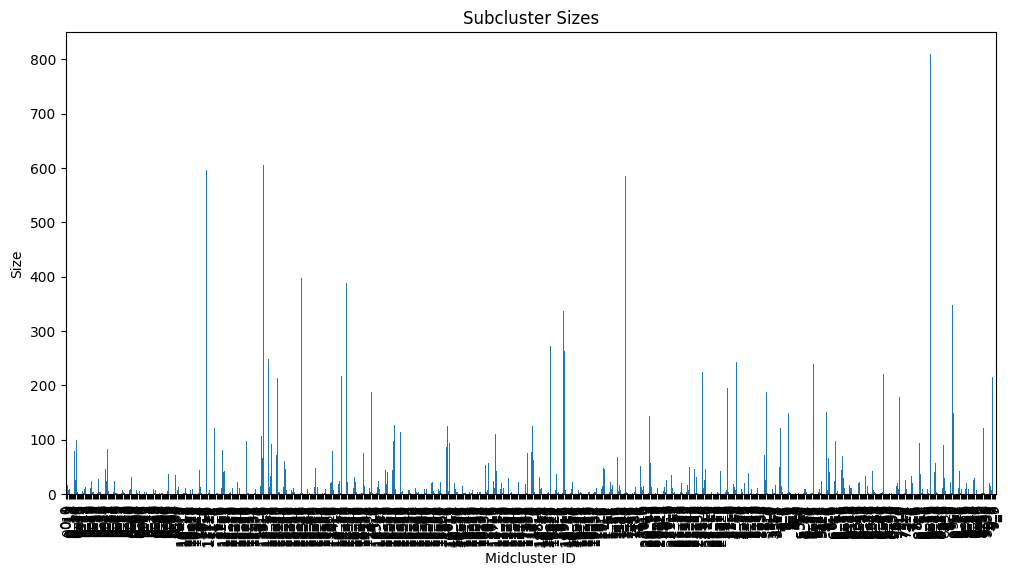

In [26]:
# 서브클러스터 크기 시각화
subcluster_sizes.plot(kind='bar', figsize=(12, 6), title='Subcluster Sizes')
plt.xlabel('Midcluster ID')
plt.ylabel('Size')
plt.show()

In [27]:
cluster_counts = df['Midcluster_ID'].value_counts()

min_samples = 100  # 입력
target_clusters = cluster_counts[cluster_counts >= min_samples].index.tolist()
print(f"소분류 대상 클러스터 개수 : {len(target_clusters)}")

소분류 대상 클러스터 개수 : 61


## 3. AGNES 소분류 (AgglomerativeClustering + distance_threshold)

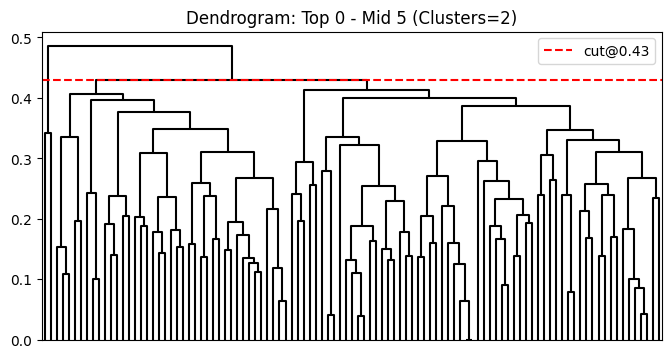

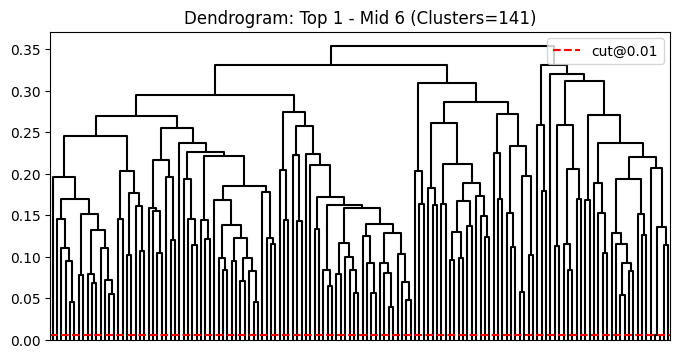

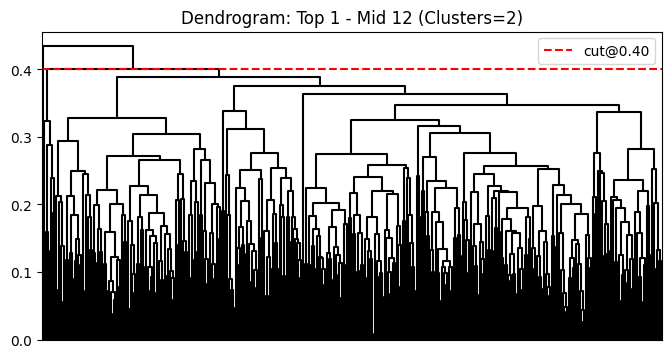

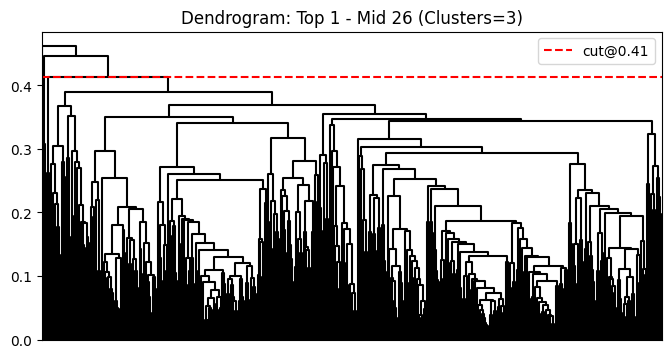

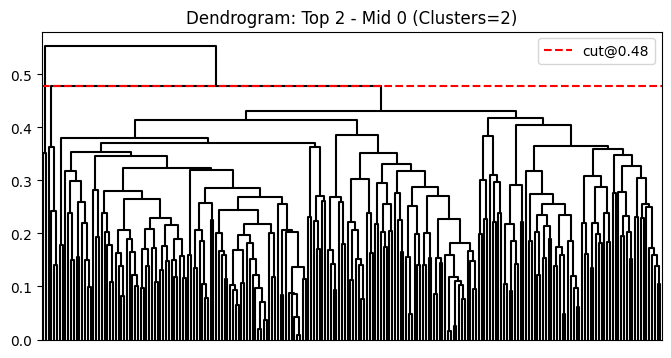

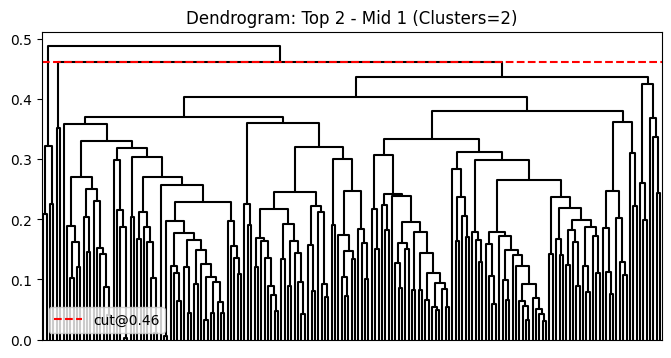

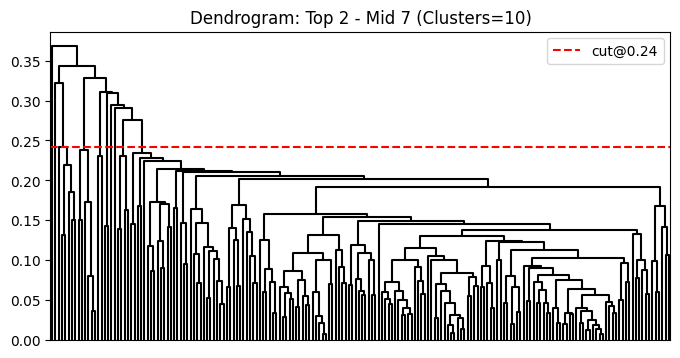

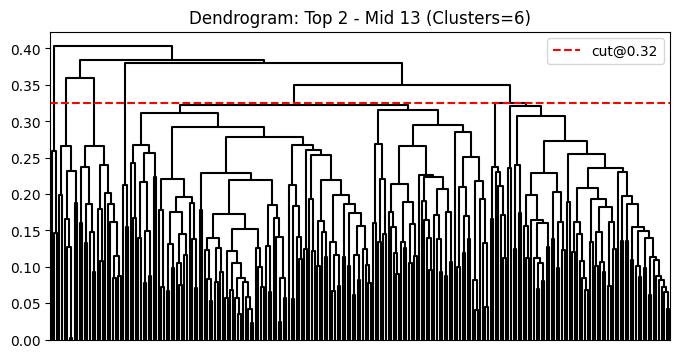

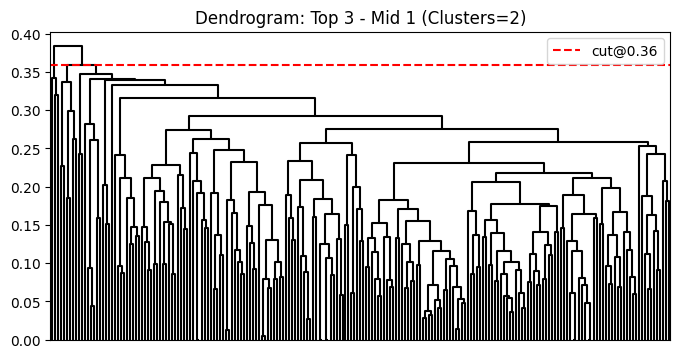

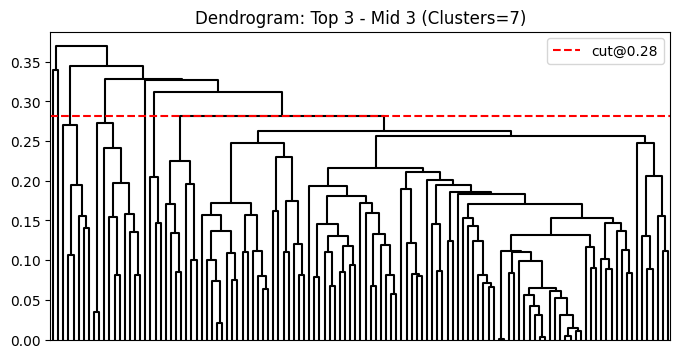

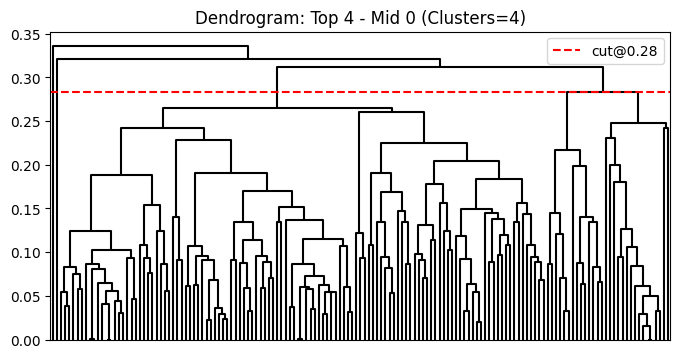

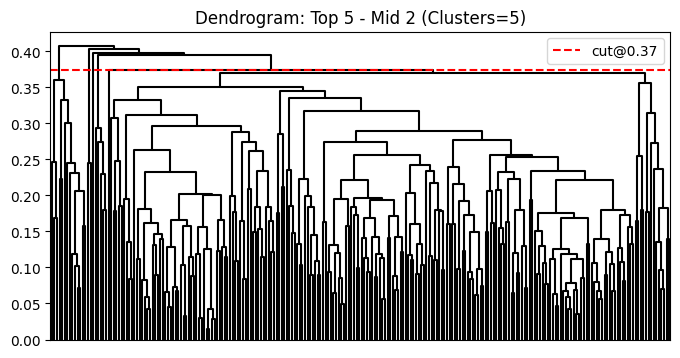

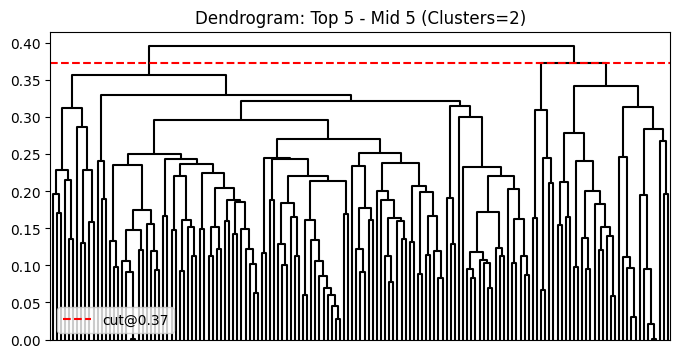

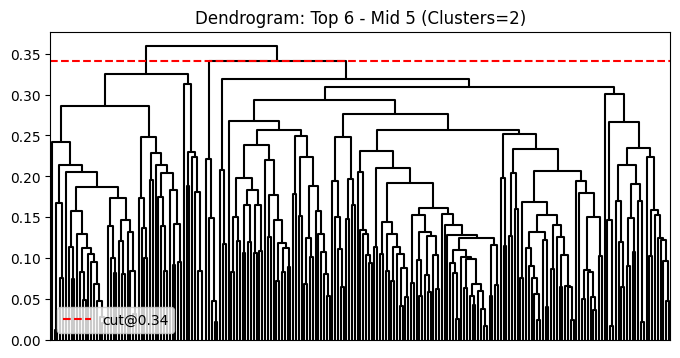

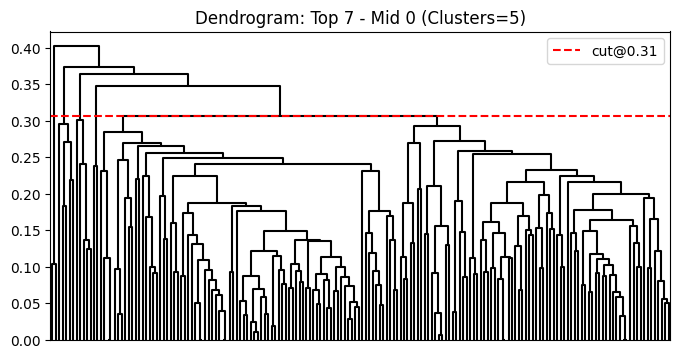

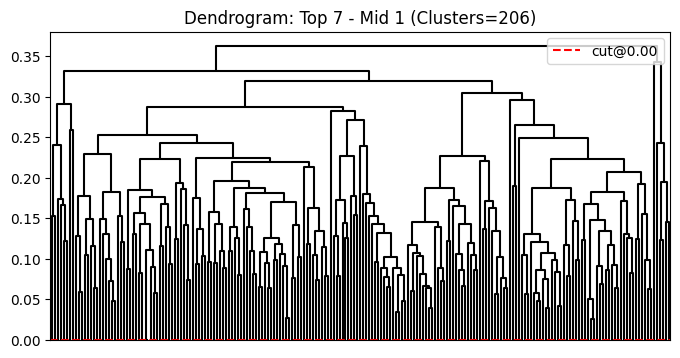

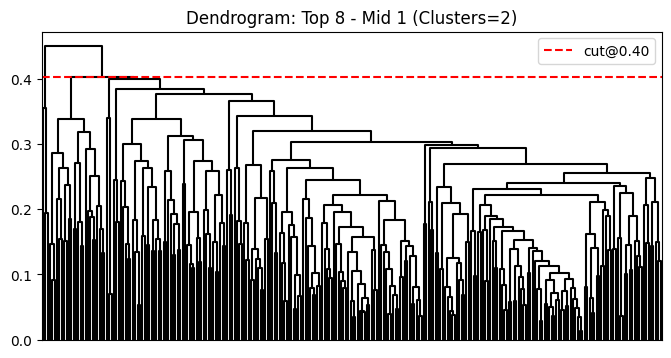

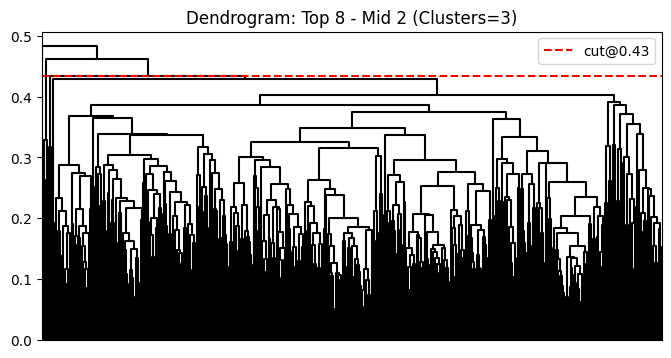

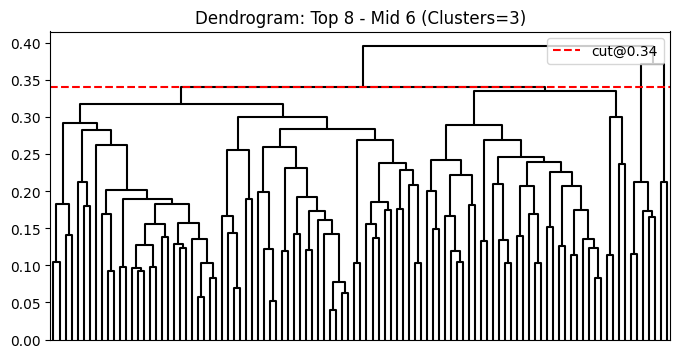

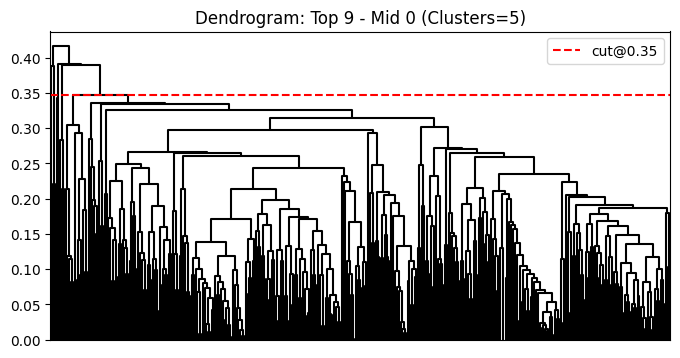

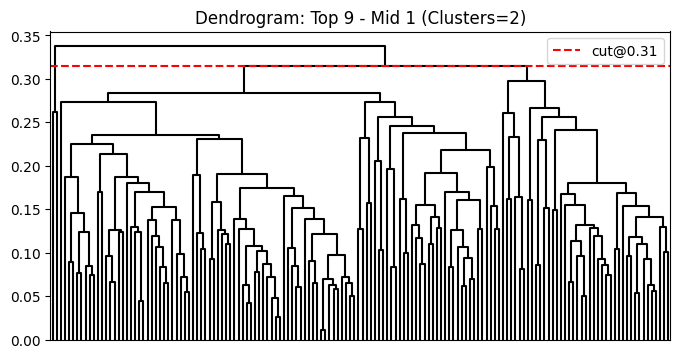

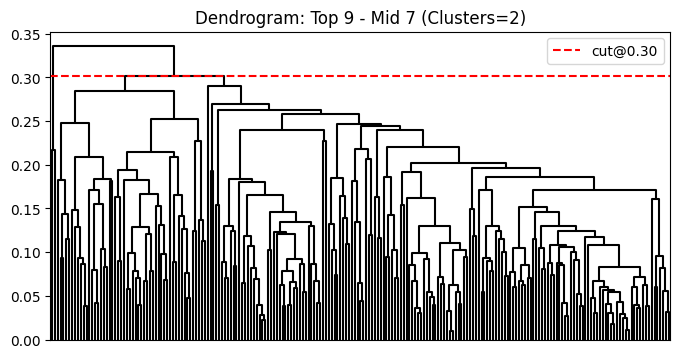

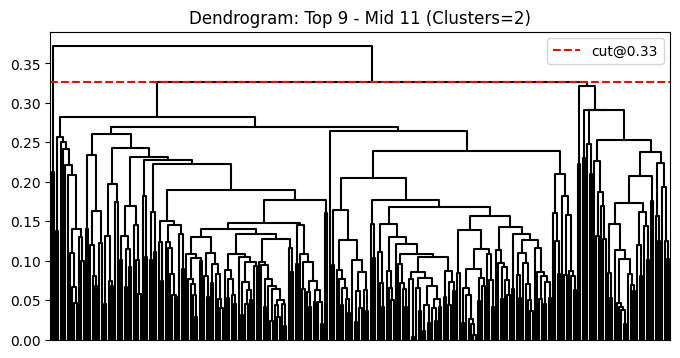

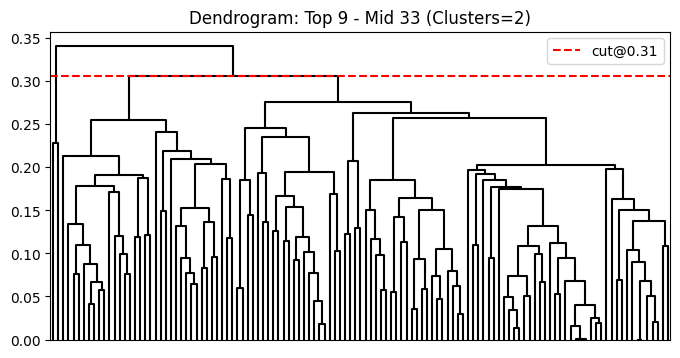

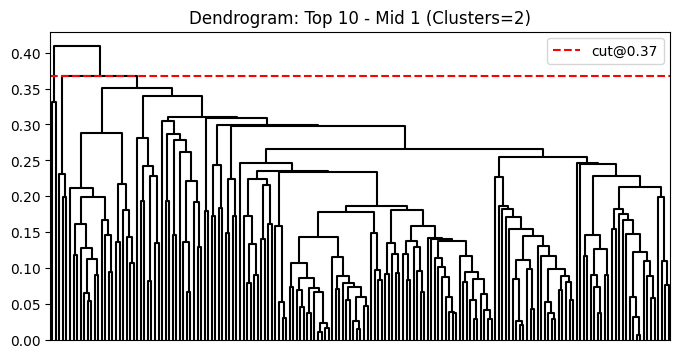

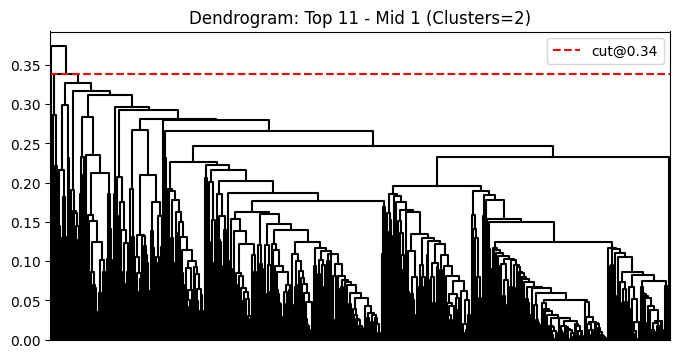

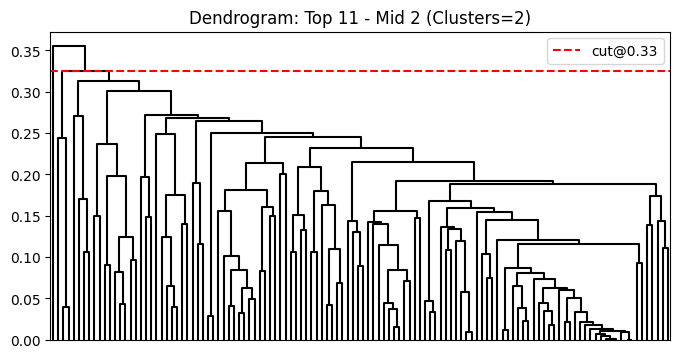

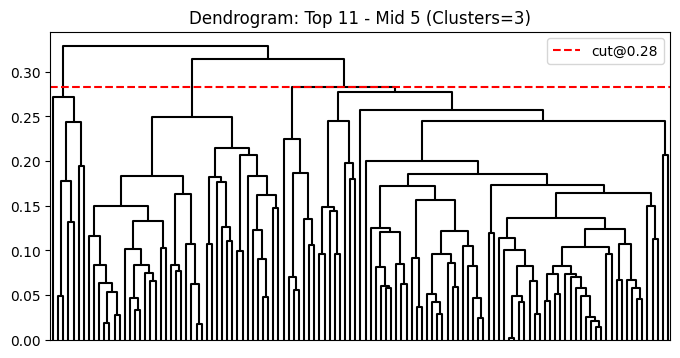

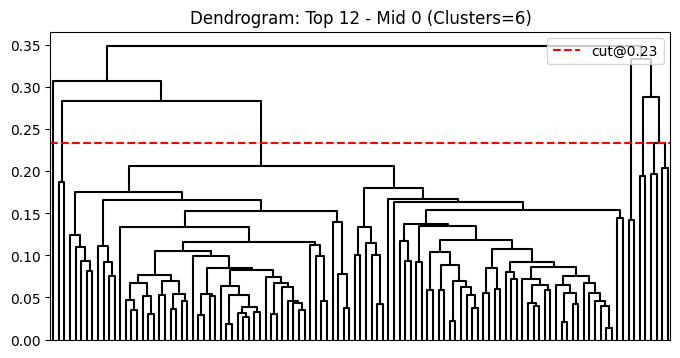

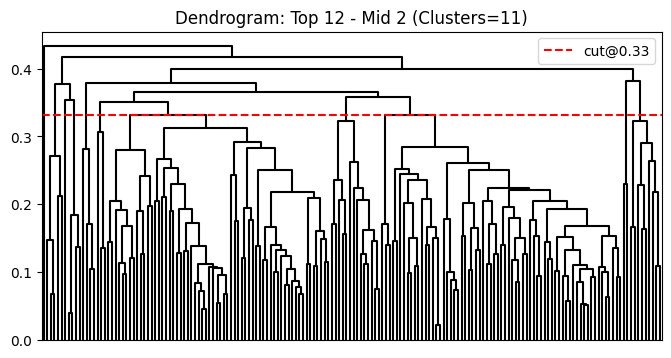

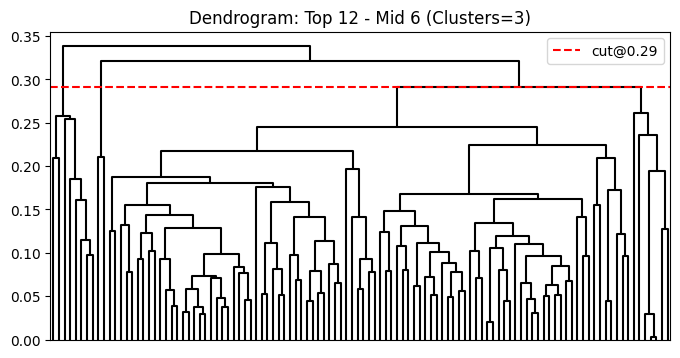

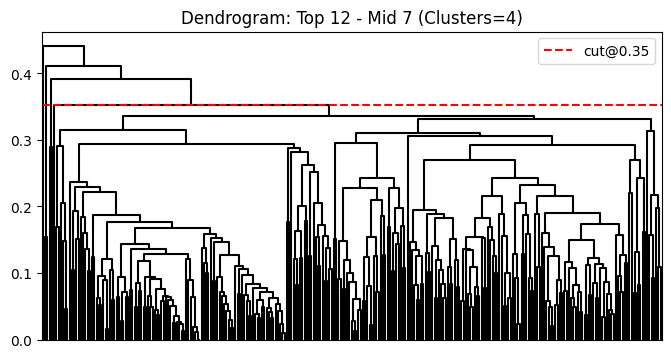

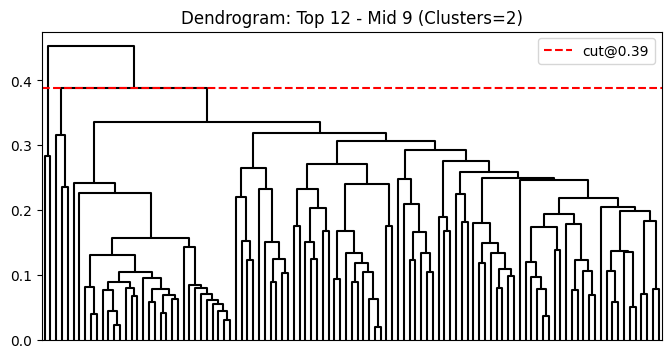

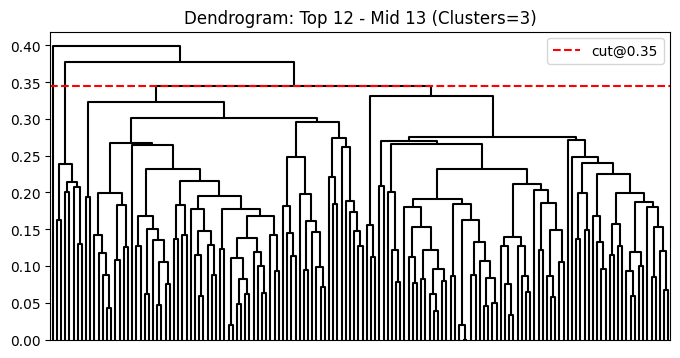

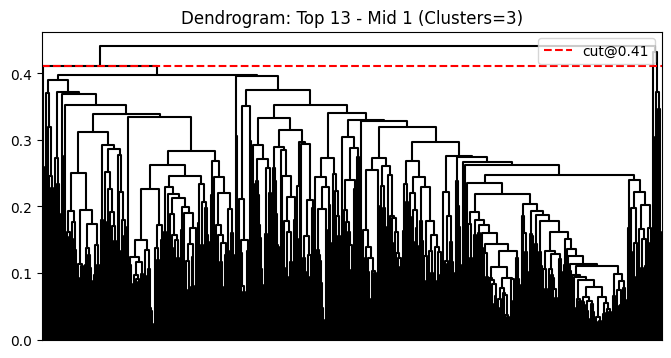

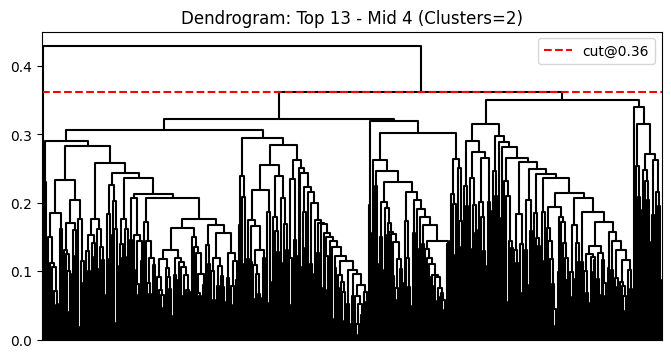

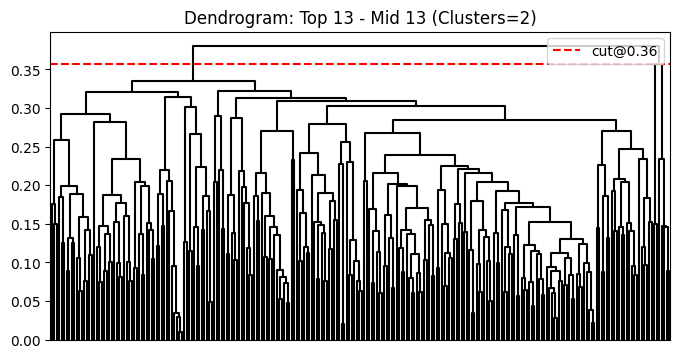

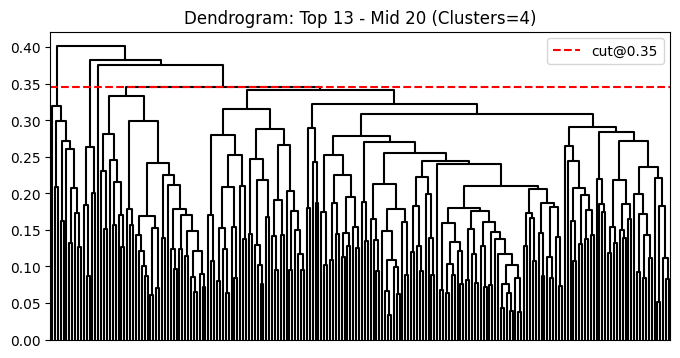

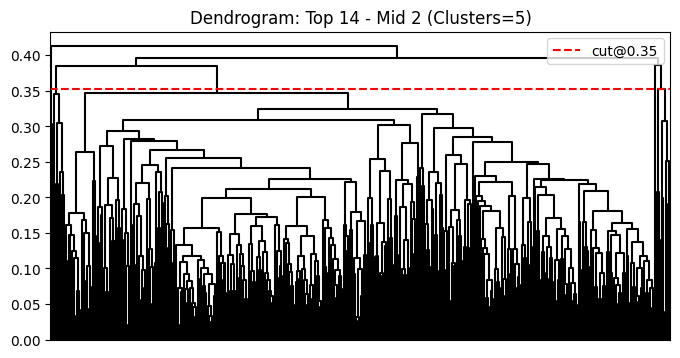

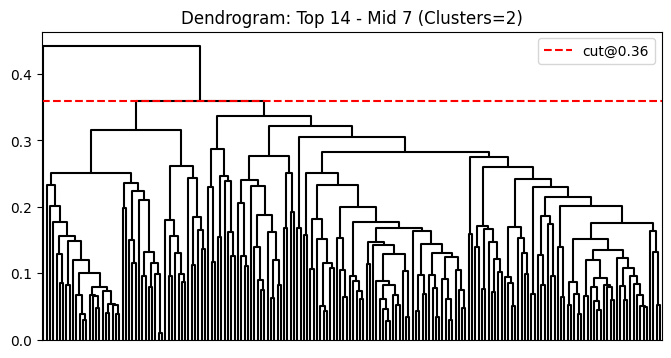

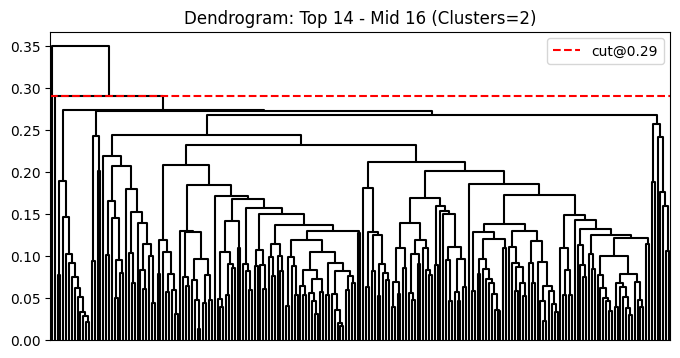

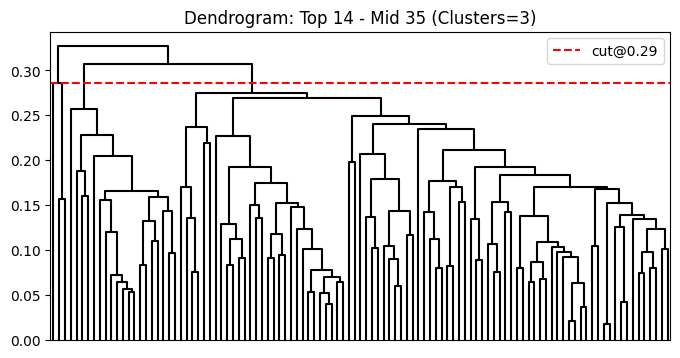

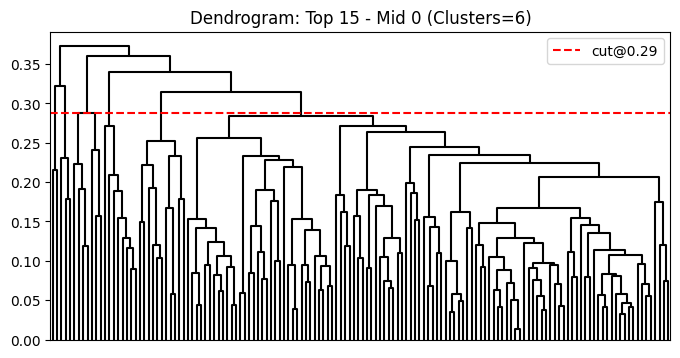

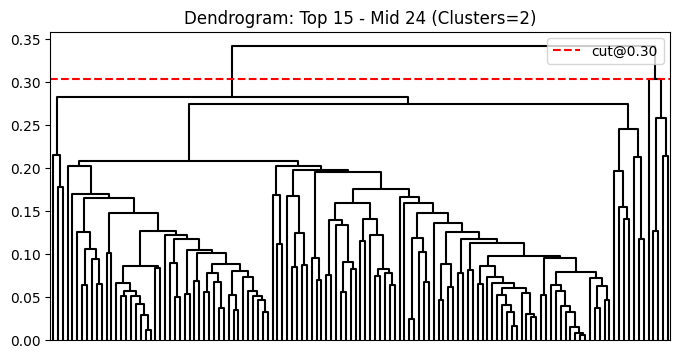

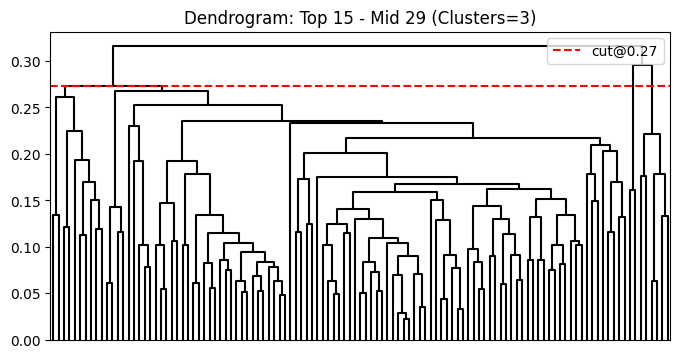

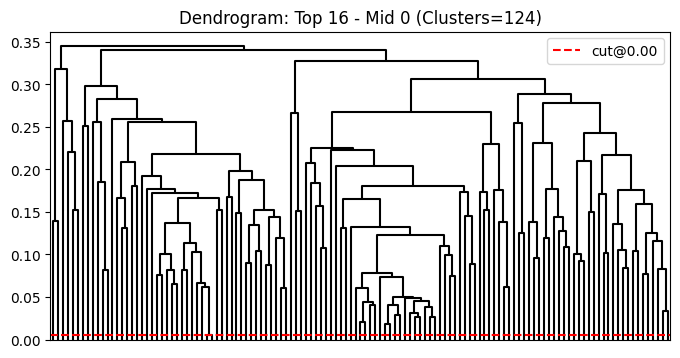

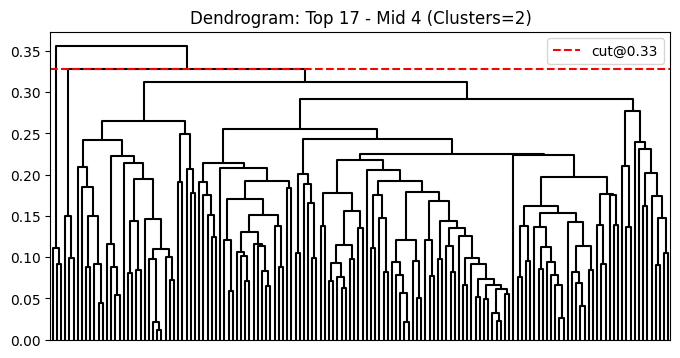

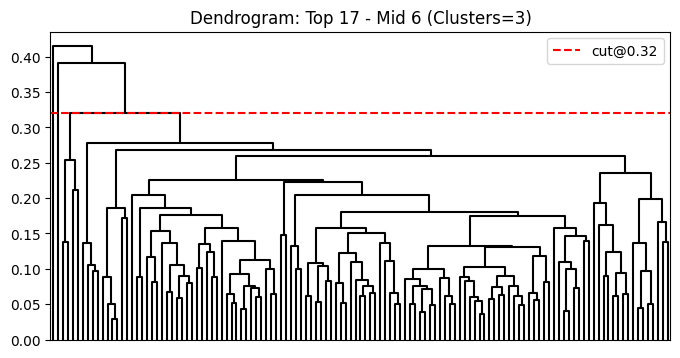

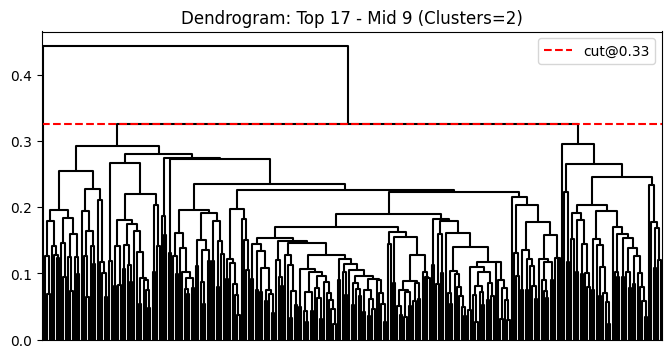

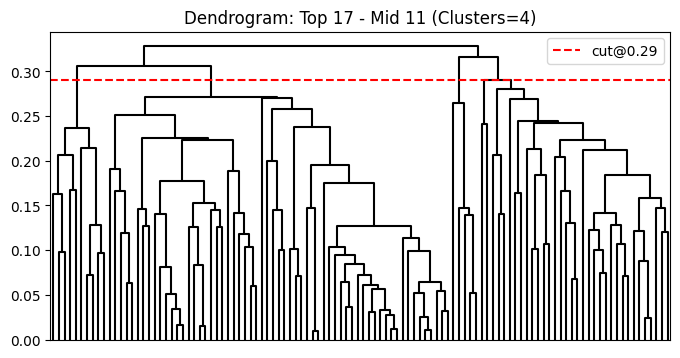

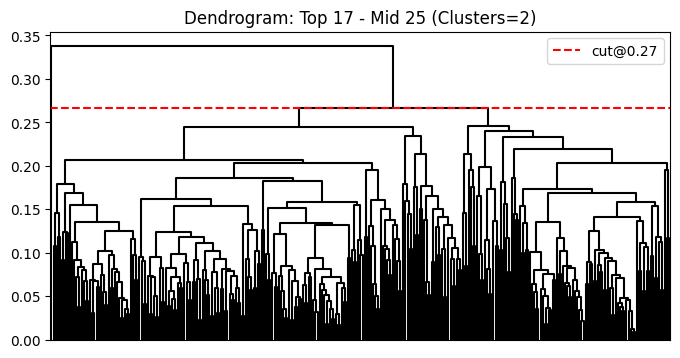

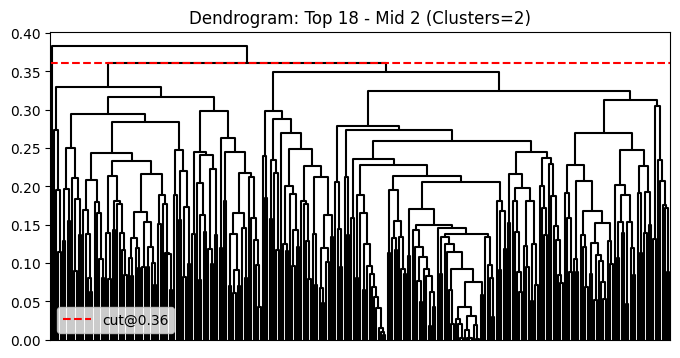

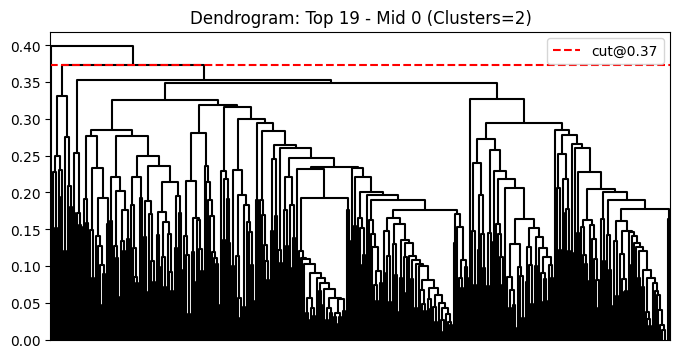

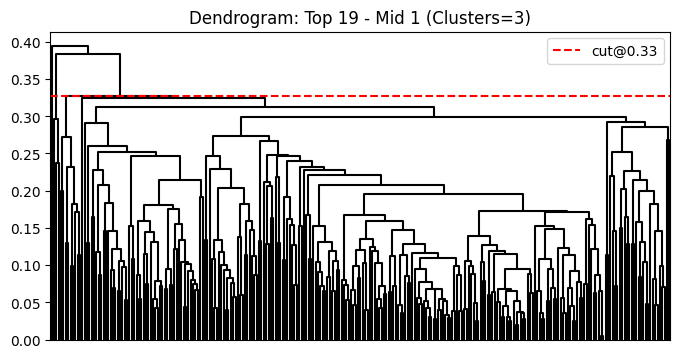

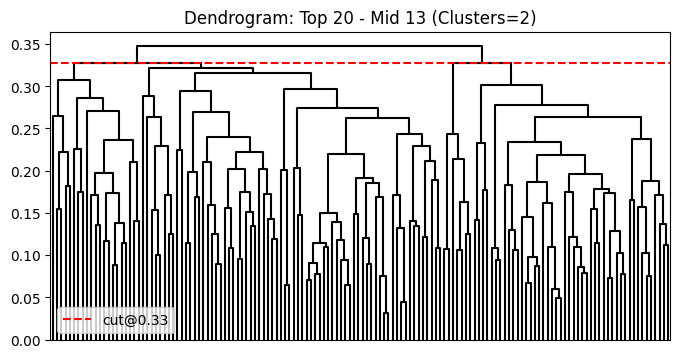

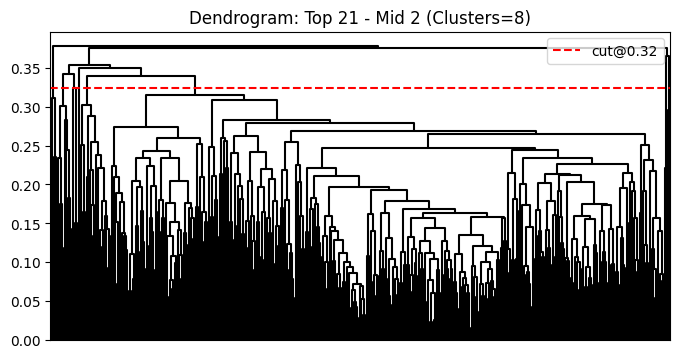

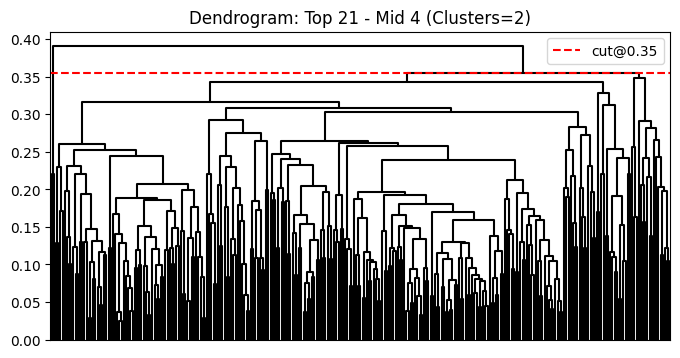

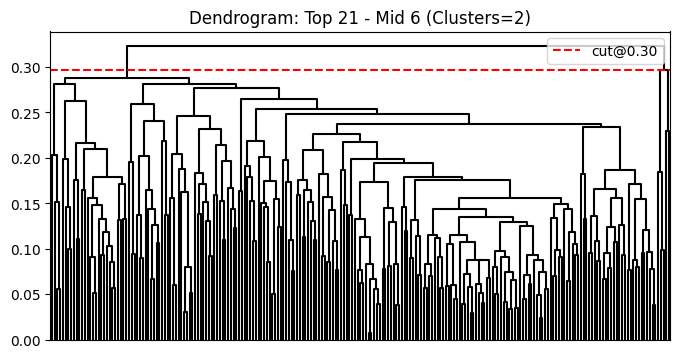

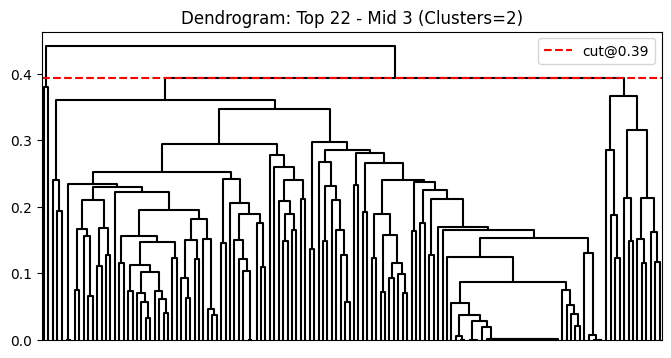

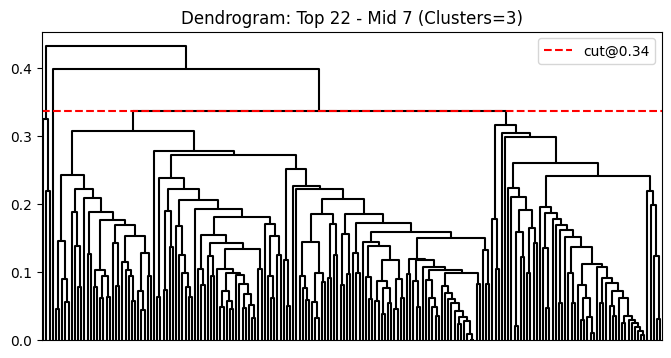

In [28]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

# 결과 저장용 컬럼 초기화
df['Subcluster'] = 0
sub_keywords_and_texts = {}

def auto_cut_dendrogram(data, method="average", metric="cosine", plot=False, cluster_name=""):
    linked = linkage(data, method=method, metric=metric)
    distances = linked[:, 2]
    deltas = np.diff(distances)
    threshold = distances[np.argmax(deltas)]

    labels = fcluster(linked, t=threshold, criterion="distance")

    if plot:
        plt.figure(figsize=(8, 4))
        dendrogram(
            linked,
            no_labels=True,
            color_threshold=0,              # 색상 구분 제거
            above_threshold_color='black'   # 모든 선 검정색
        )
        plt.axhline(y=threshold, color='red', linestyle='--', label=f"cut@{threshold:.2f}")
        plt.title(f"Dendrogram: {cluster_name} (Clusters={len(set(labels))})")
        plt.legend()
        plt.show()

    return labels, threshold

# 벡터 컬럼 (64차원 임베딩)
vec_cols = list(map(str, range(64)))

# Topcluster → Midcluster 단위로 AGNES 소분류 수행
for top_id in sorted(df['Topcluster'].unique()):
    top_df = df[df['Topcluster'] == top_id]

    for mid_id in sorted(top_df['Midcluster'].unique()):
        sub_df = top_df[top_df['Midcluster'] == mid_id]
        if len(sub_df) <= 100:
            continue  # 소분류 의미 없을 정도로 작으면 스킵

        vectors = sub_df[vec_cols].values
        texts = sub_df['generated_summary'].tolist()
        indices = sub_df.index.tolist()

        # AGNES 기반 덴드로그램 컷팅 + 시각화
        sub_labels, threshold = auto_cut_dendrogram(
            data=vectors,
            plot=True,
            cluster_name=f"Top {top_id} - Mid {mid_id}"
        )

        # 소분류 레이블 저장
        df.loc[indices, 'Subcluster'] = sub_labels

        # 소분류별 키워드 추출
        for sub_id in sorted(set(sub_labels)):
            sub_idx = [i for i, l in enumerate(sub_labels) if l == sub_id]
            sub_texts = [texts[i] for i in sub_idx]
            if len(sub_texts) < 3:
                continue  # LDA 돌리기에는 너무 적음

            tfidf = TfidfVectorizer(max_features=30)
            X_tfidf = tfidf.fit_transform(sub_texts)
            tfidf_keywords = tfidf.get_feature_names_out()

            lda = LatentDirichletAllocation(n_components=1, random_state=42)
            lda.fit(X_tfidf)
            lda_keywords = [
                tfidf.get_feature_names_out()[i]
                for i in lda.components_[0].argsort()[-10:][::-1]
            ]

            sub_keywords_and_texts[f"{top_id}-{mid_id}-{sub_id}"] = {
                'TFIDF': tfidf_keywords.tolist(),
                'LDA': lda_keywords
            }

# Subcluster ID 생성
df['Subcluster_ID'] = (
    df['Topcluster'].astype(str) + "_" +
    df['Midcluster'].astype(str) + "_" +
    df['Subcluster'].astype(str)
)


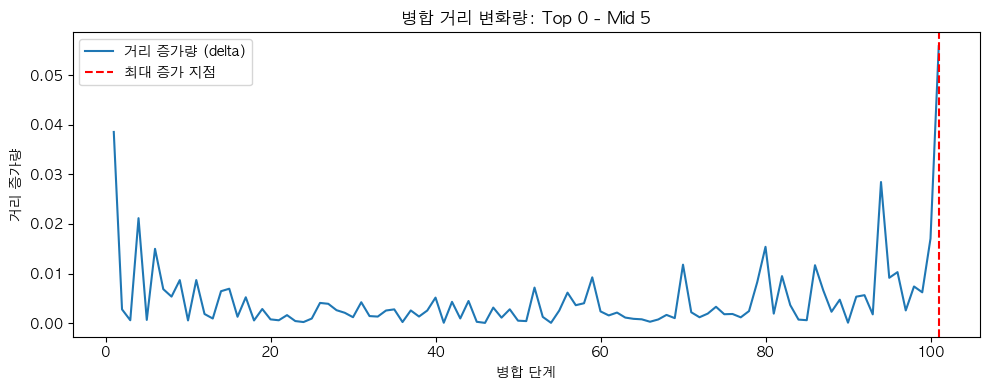

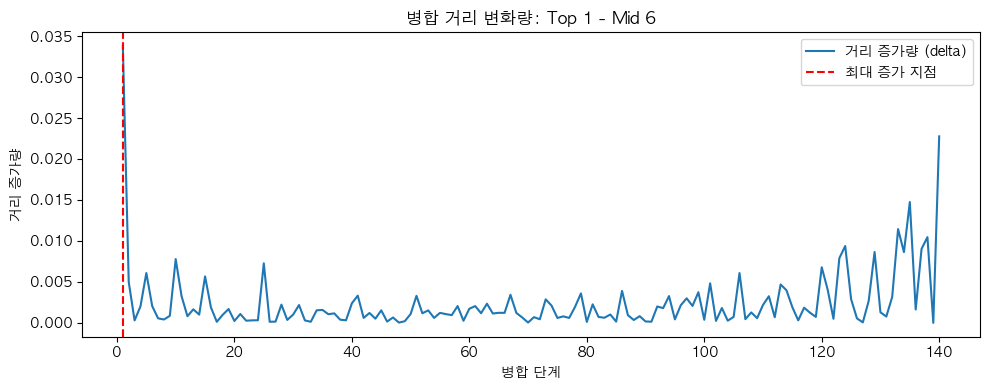

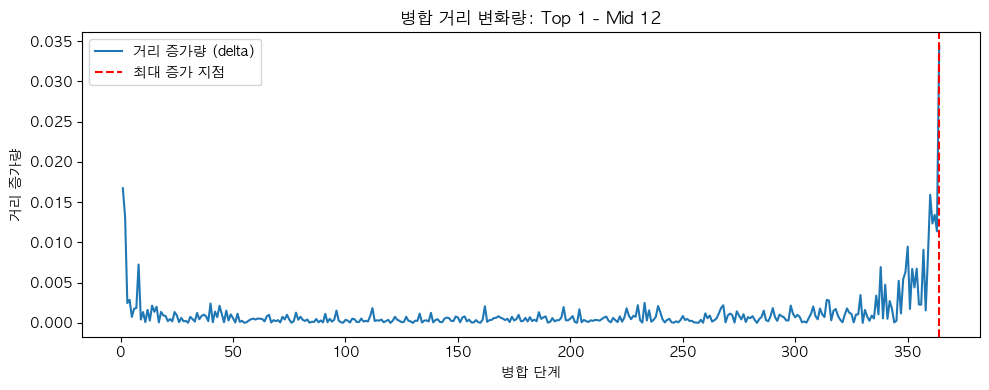

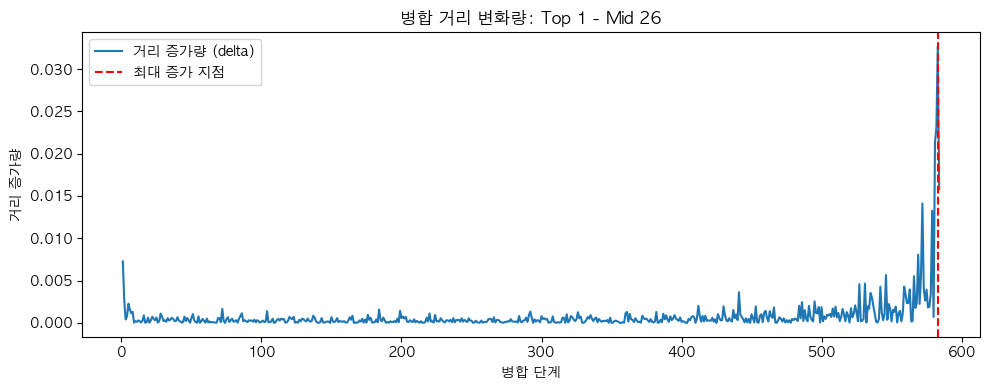

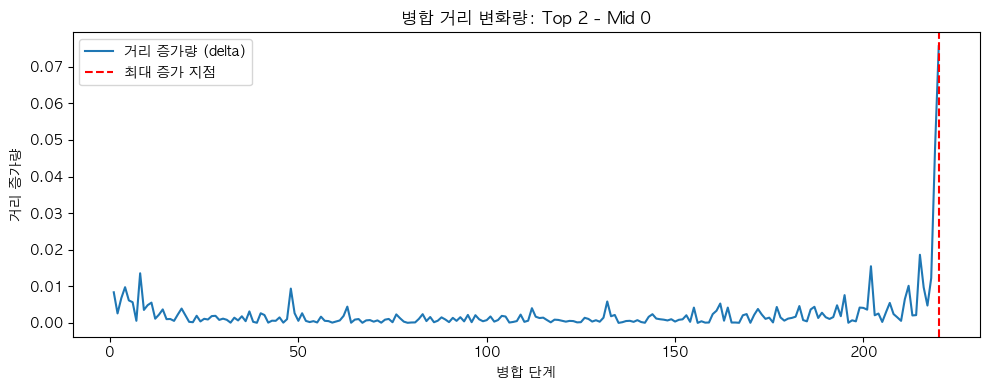

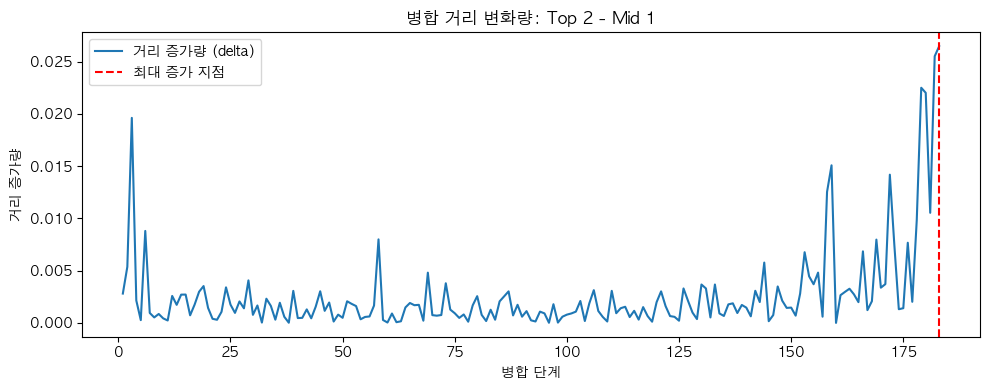

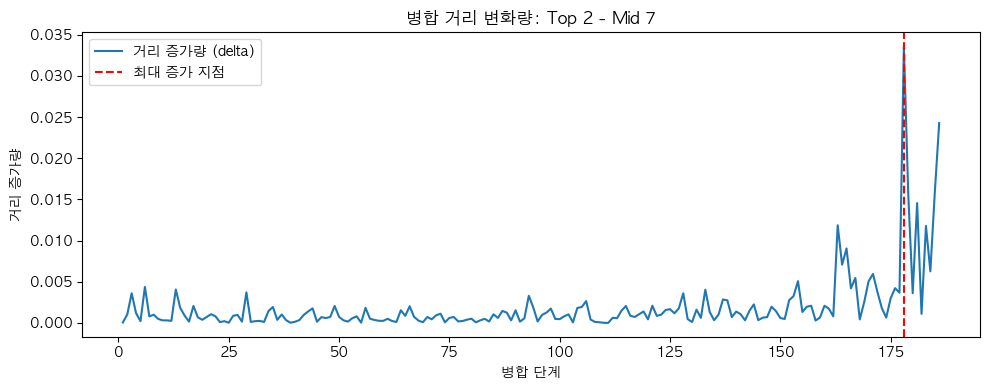

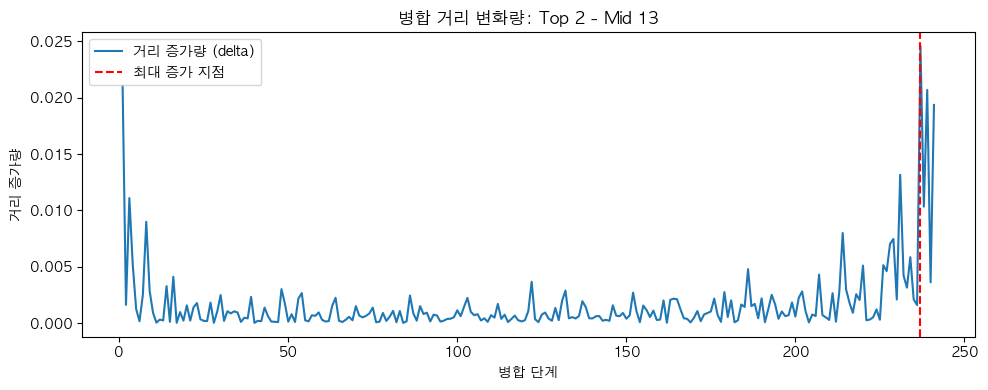

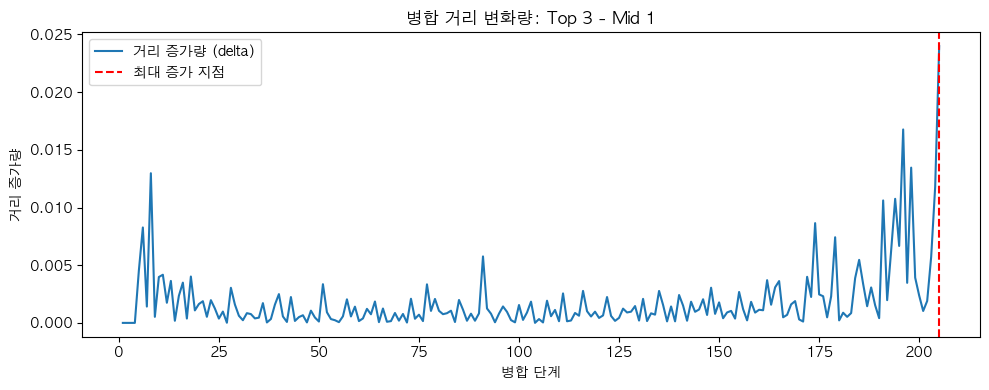

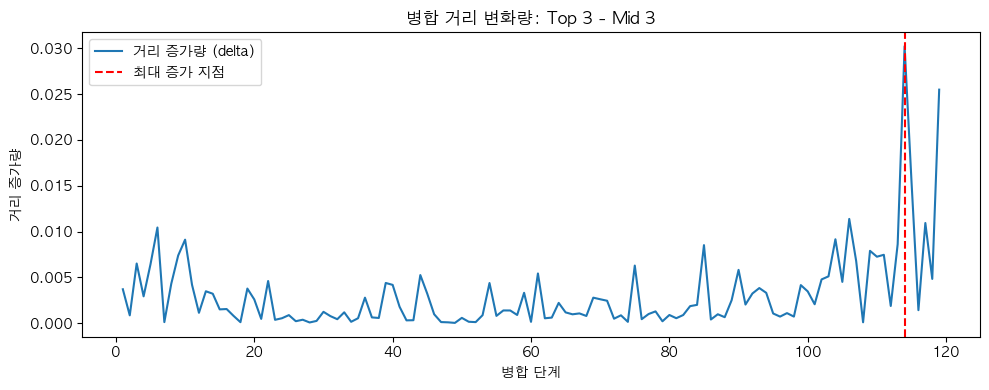

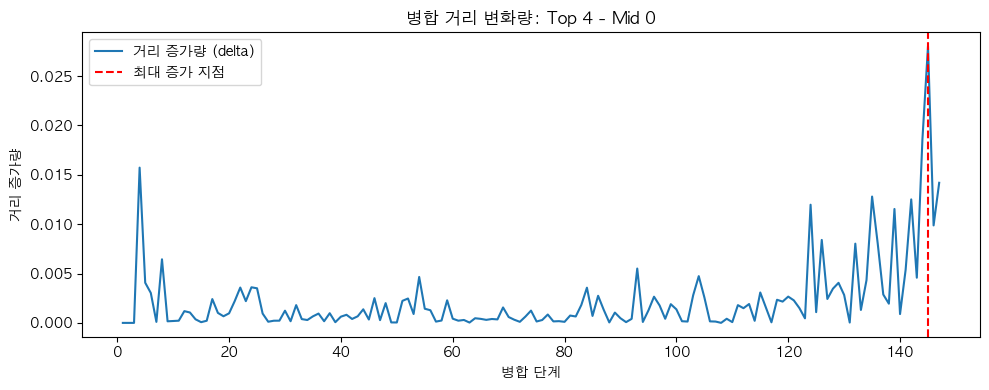

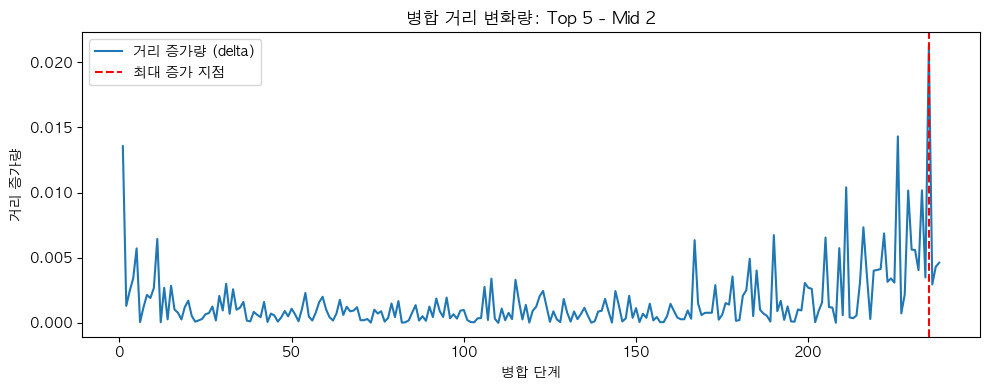

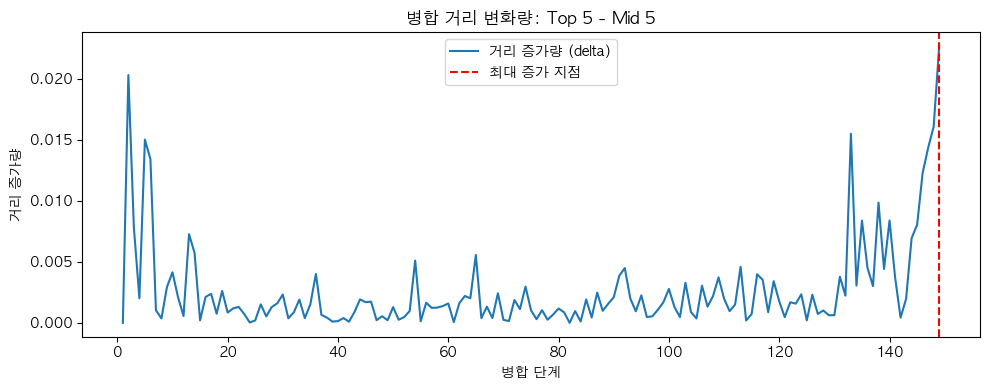

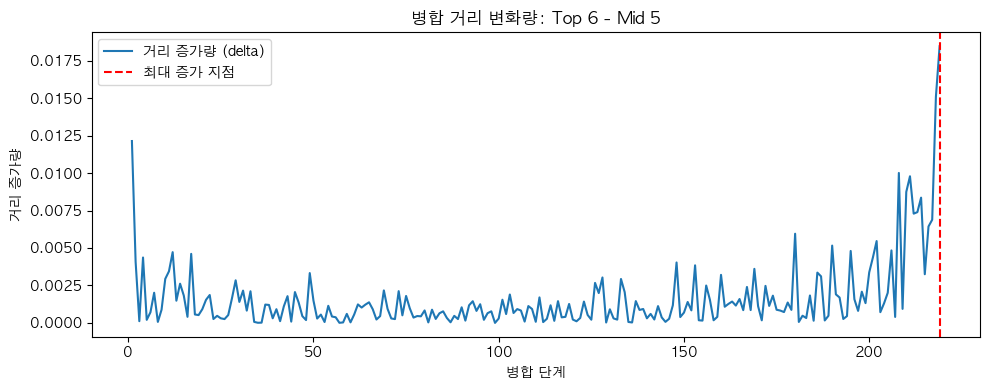

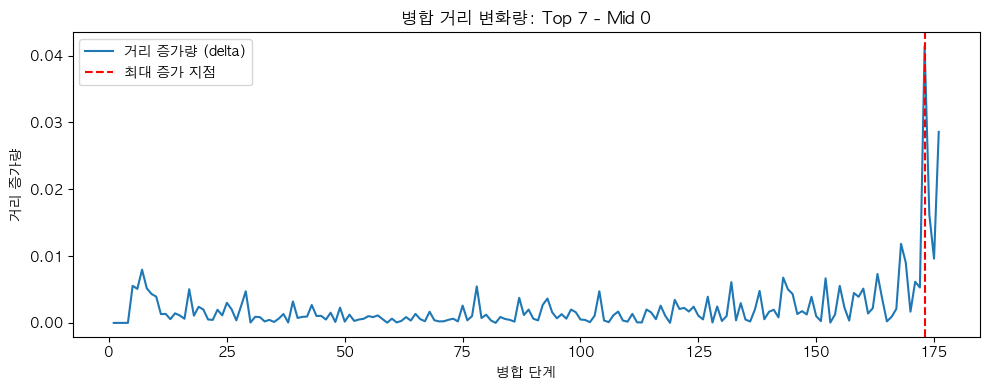

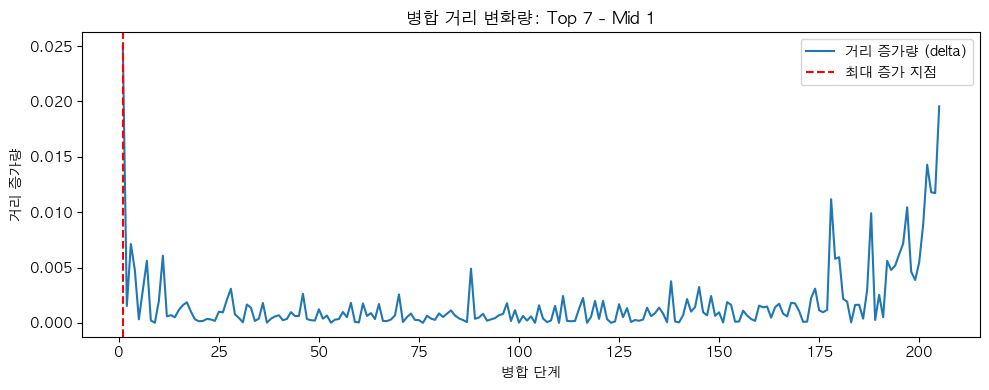

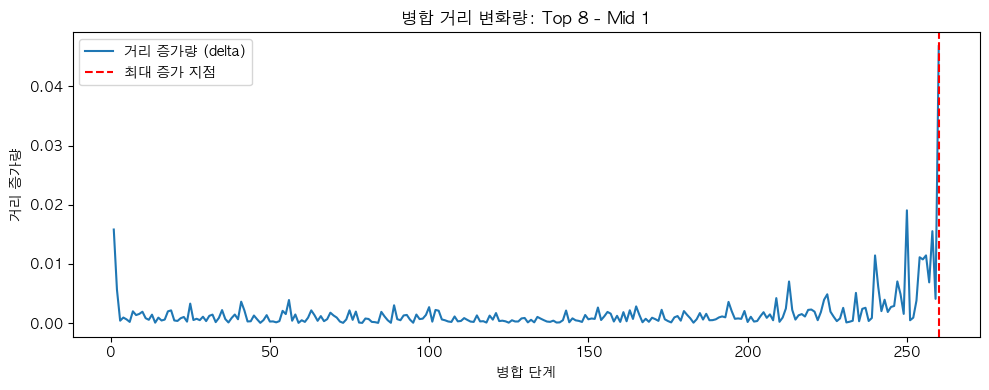

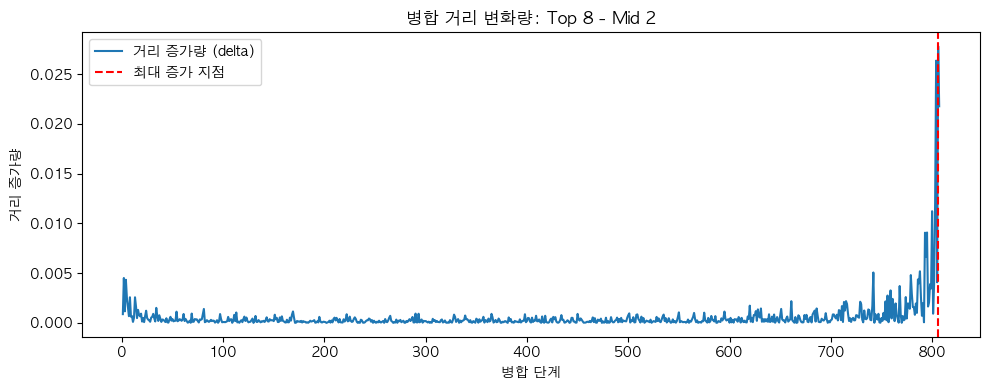

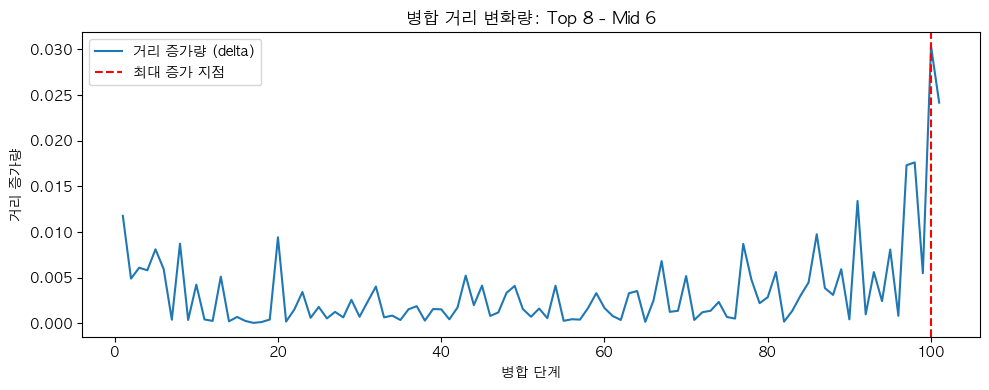

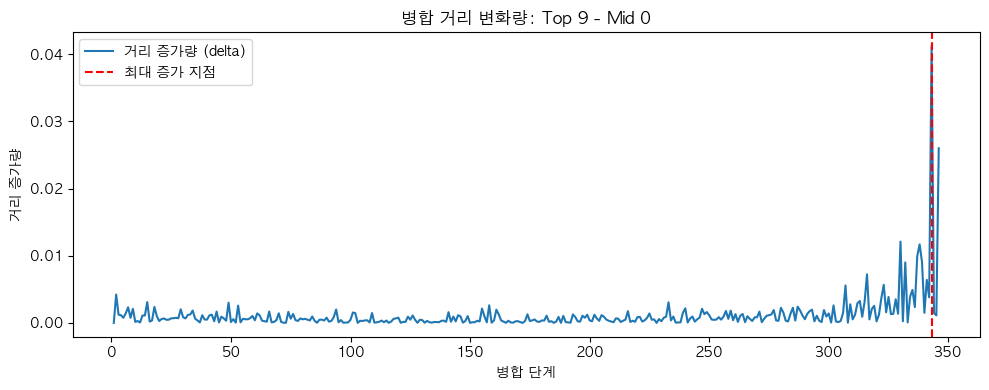

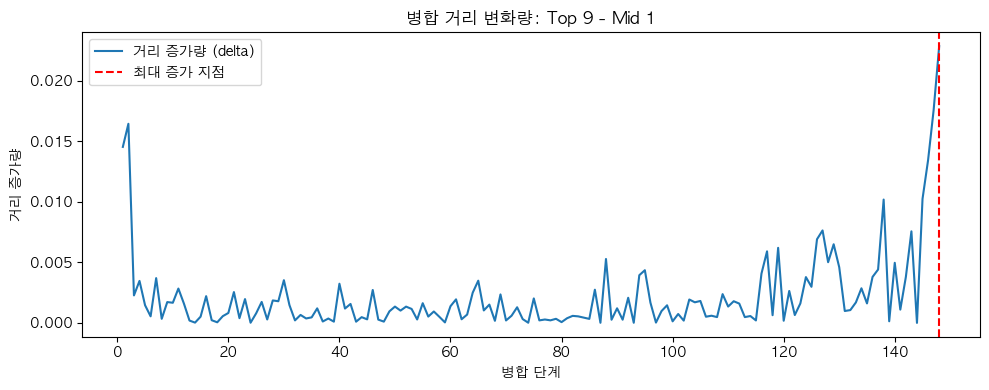

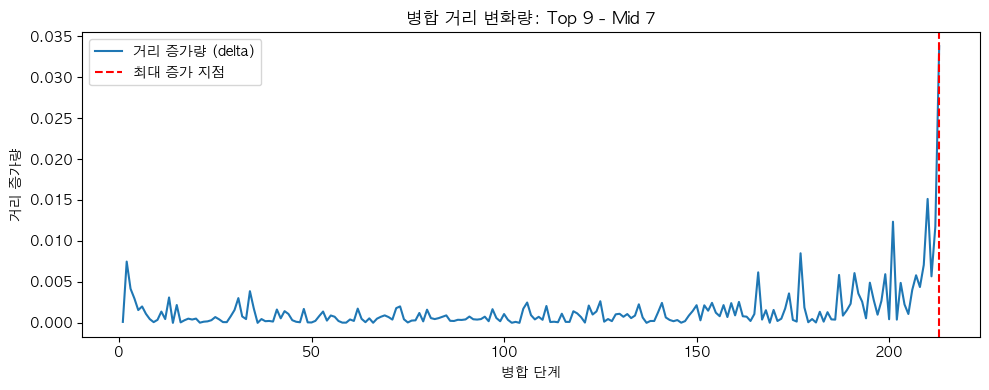

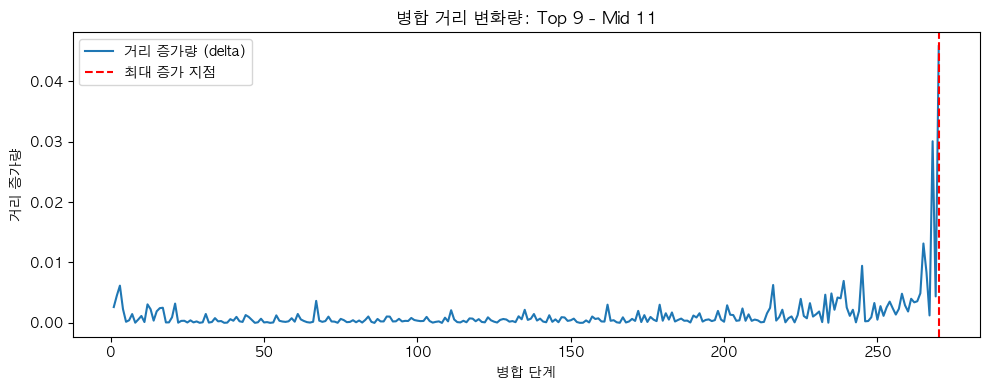

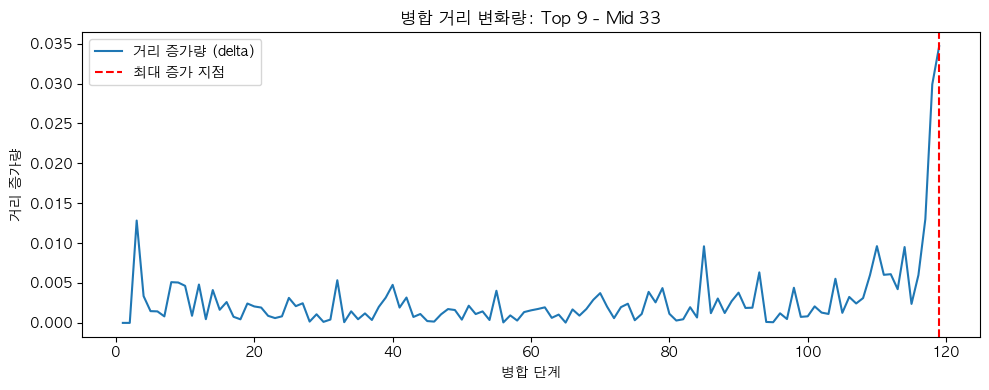

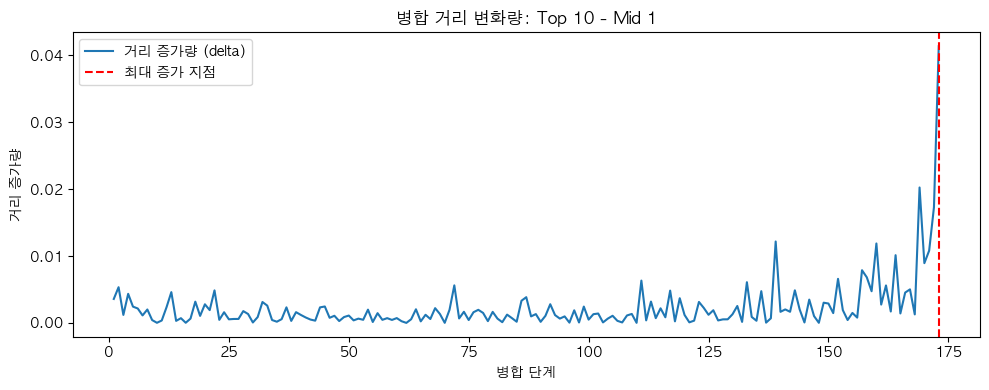

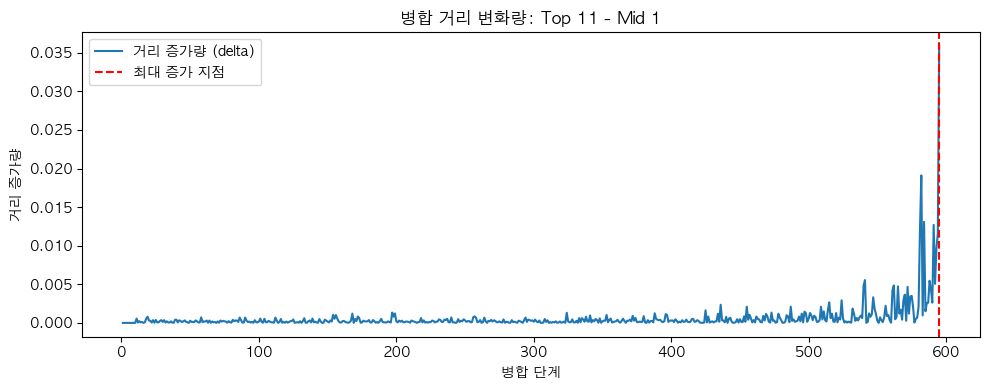

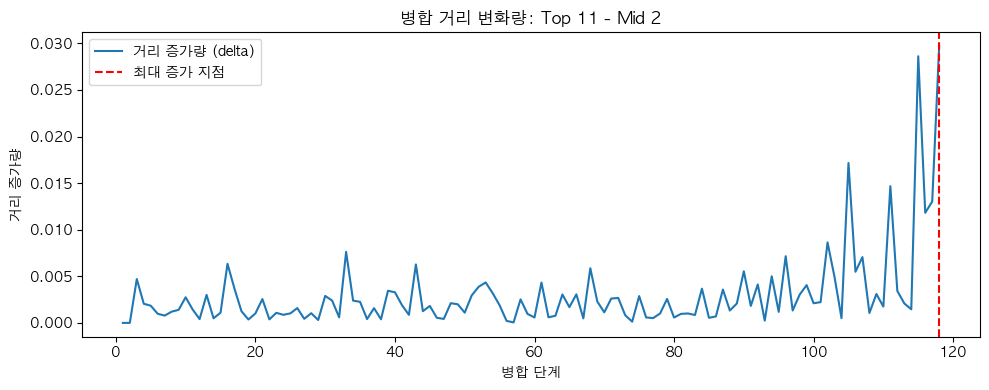

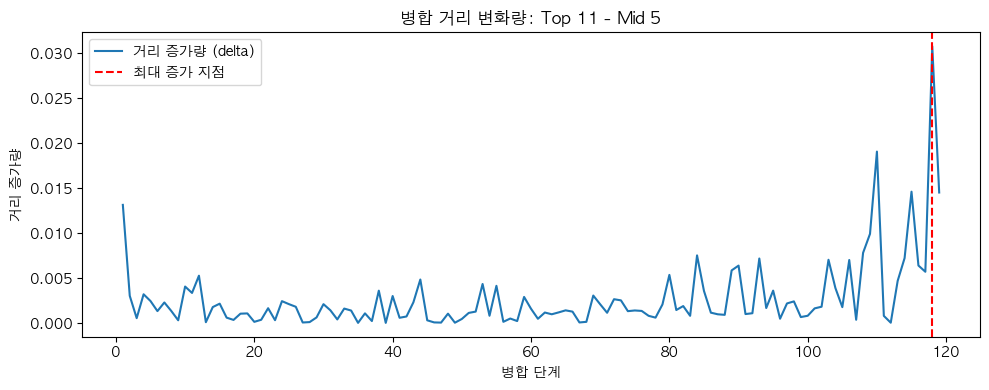

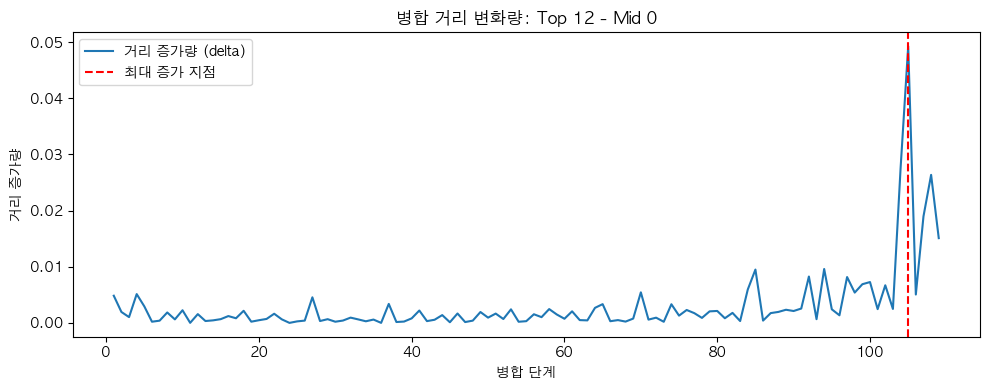

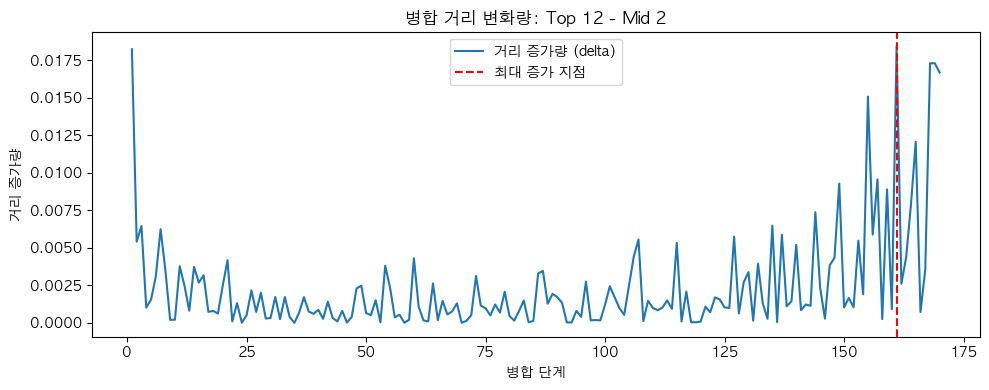

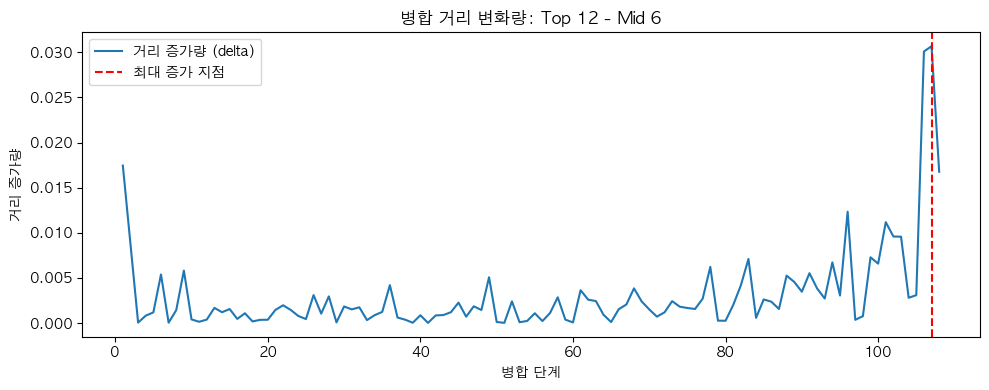

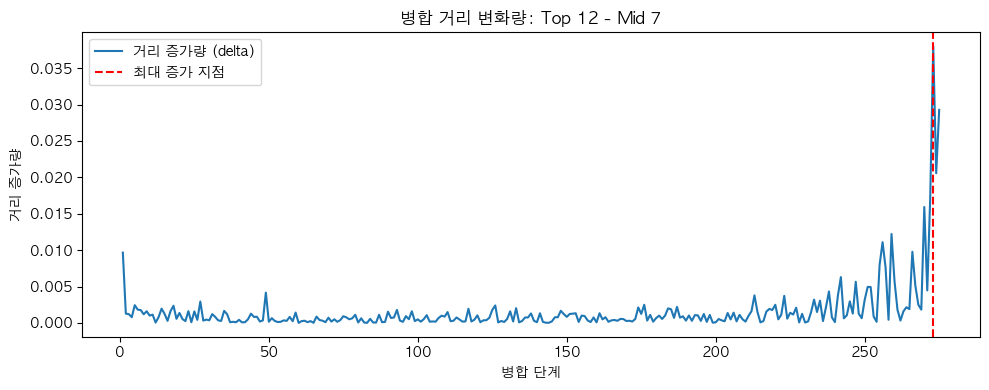

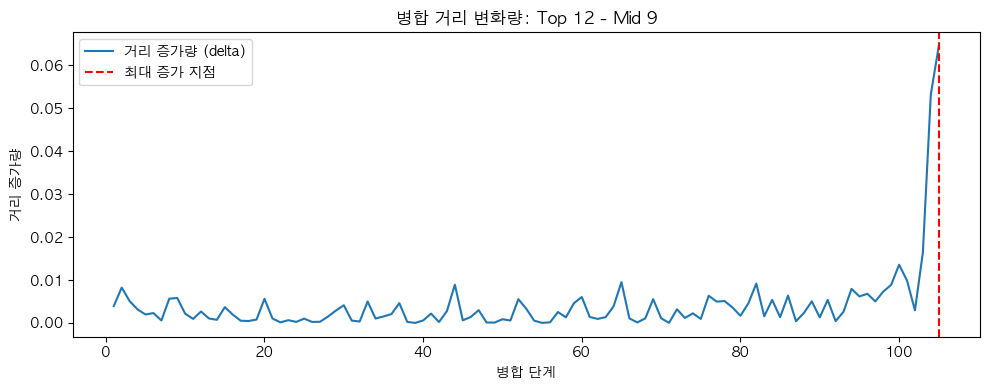

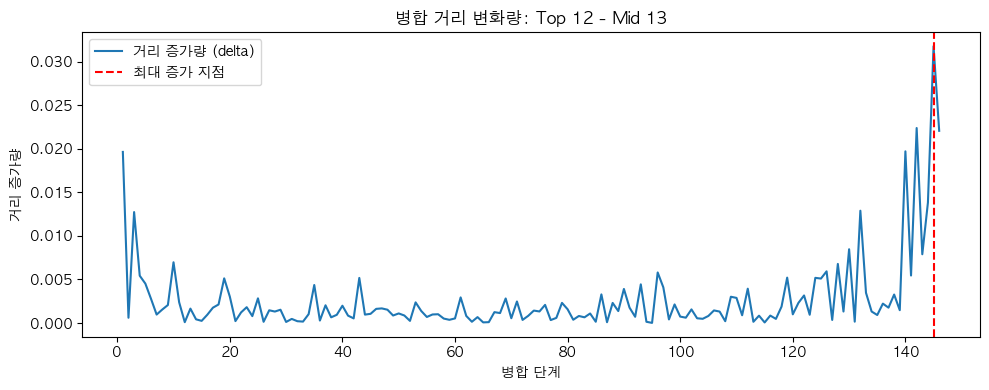

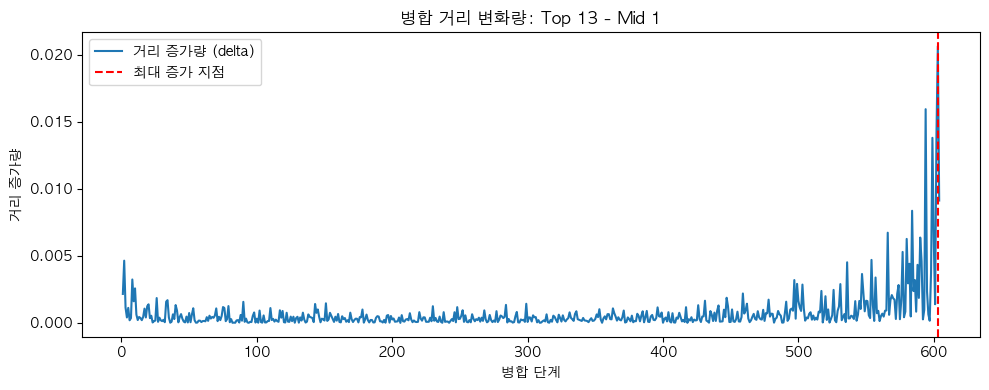

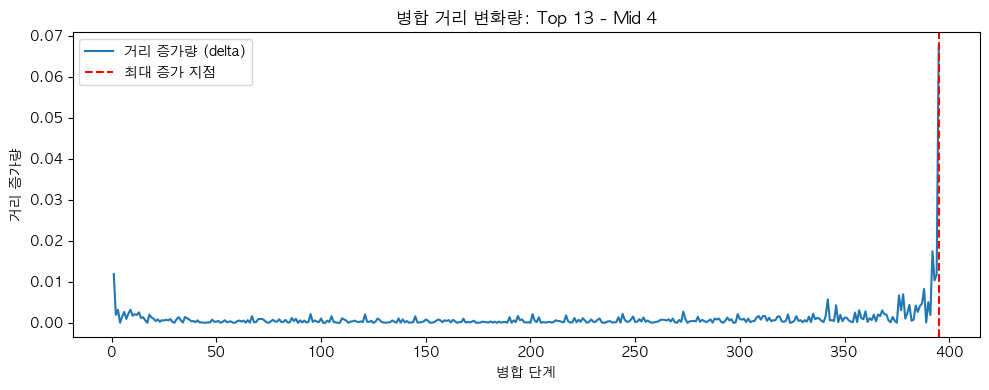

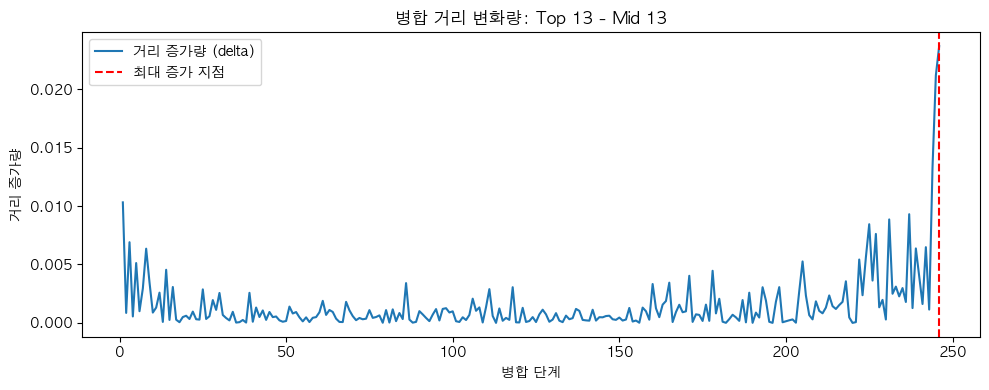

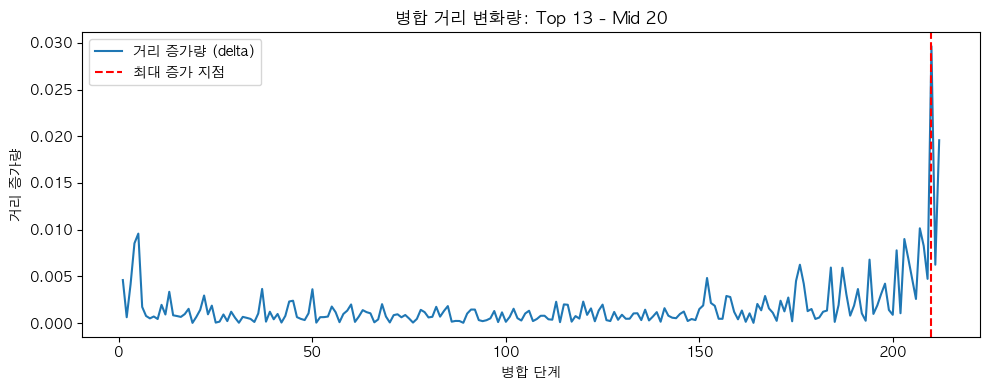

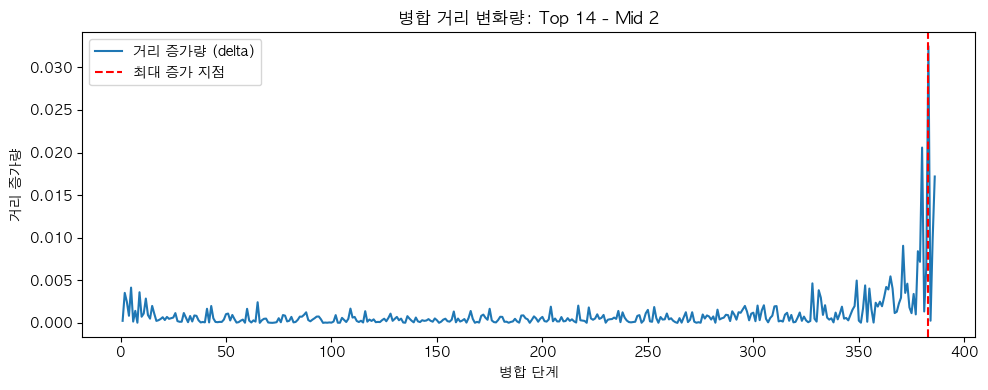

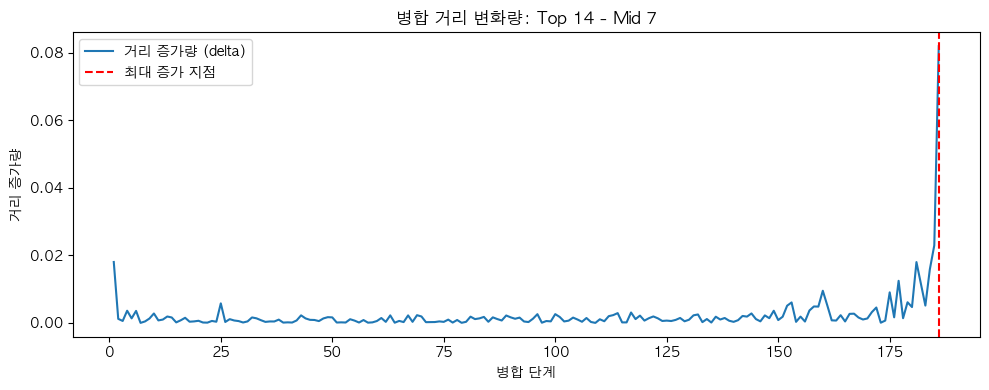

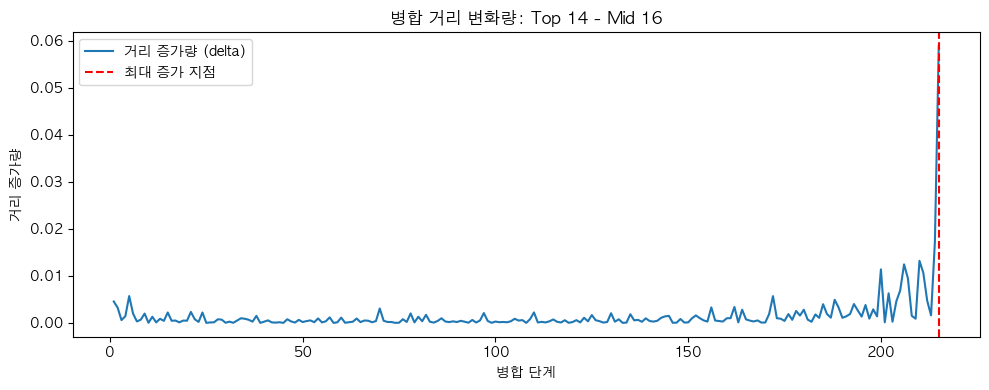

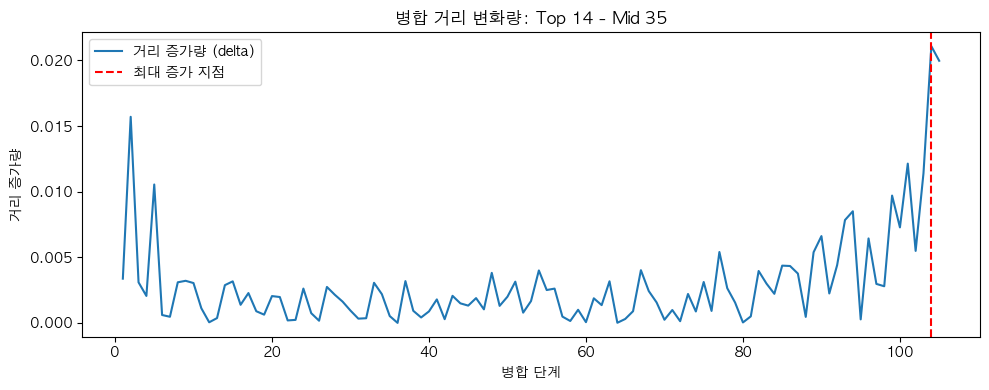

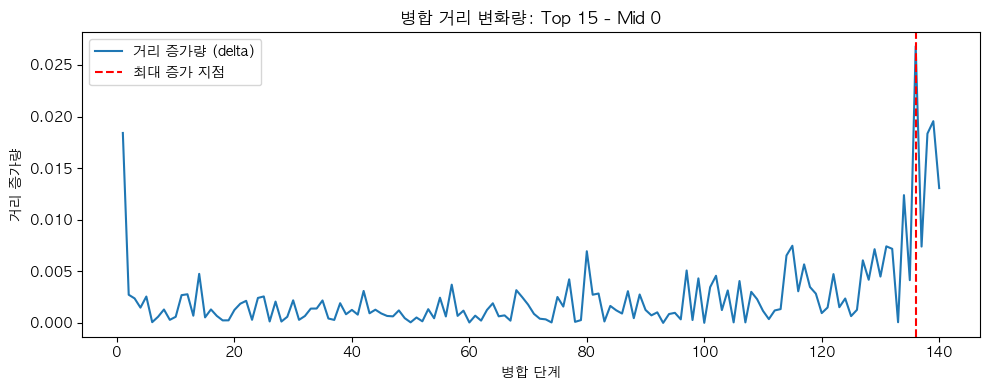

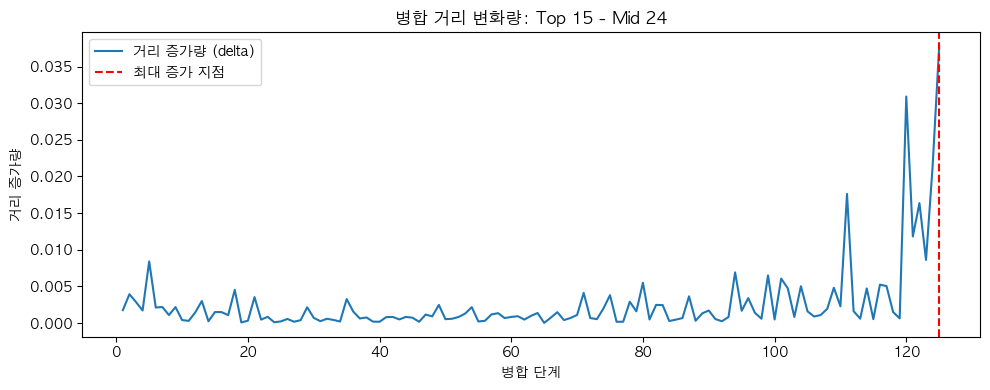

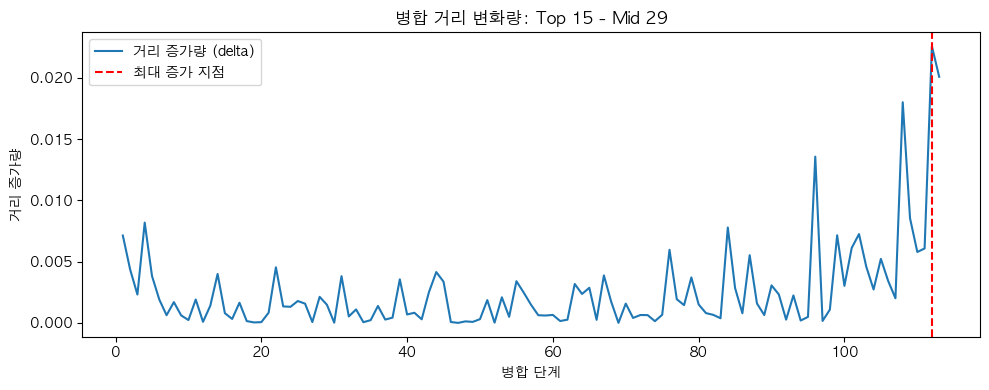

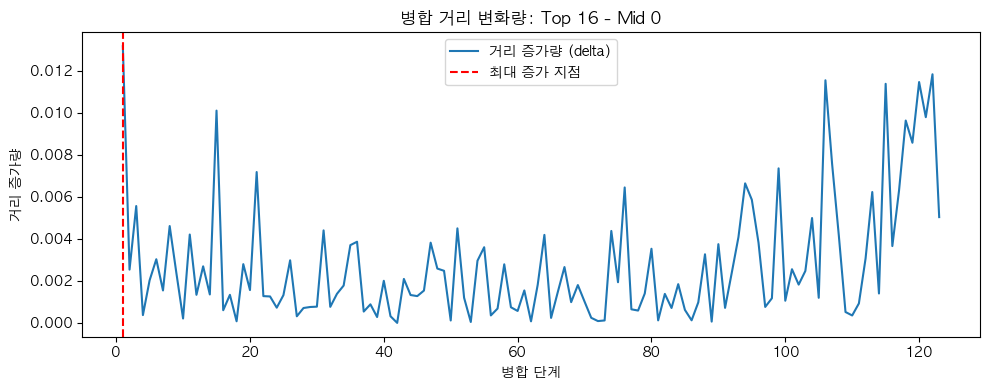

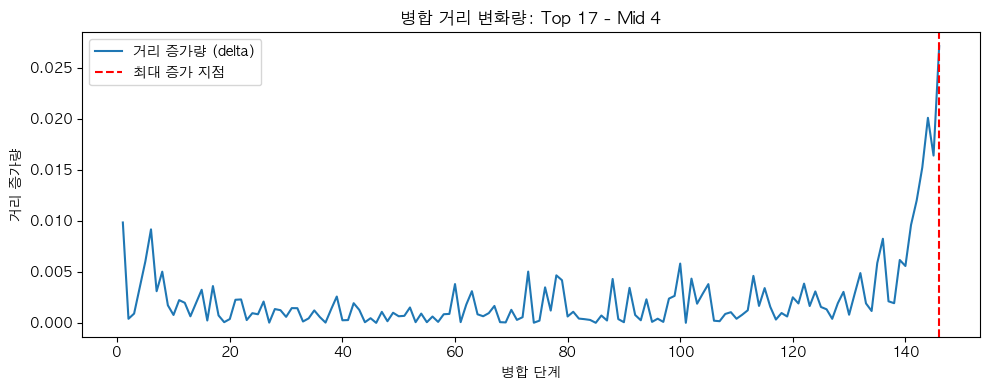

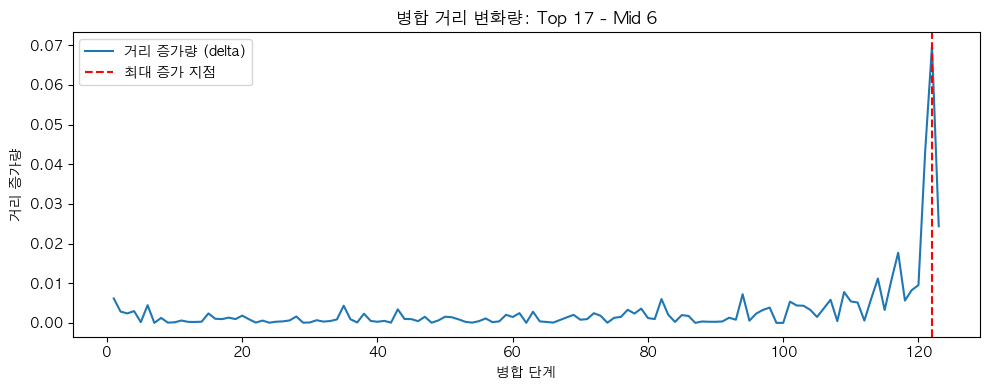

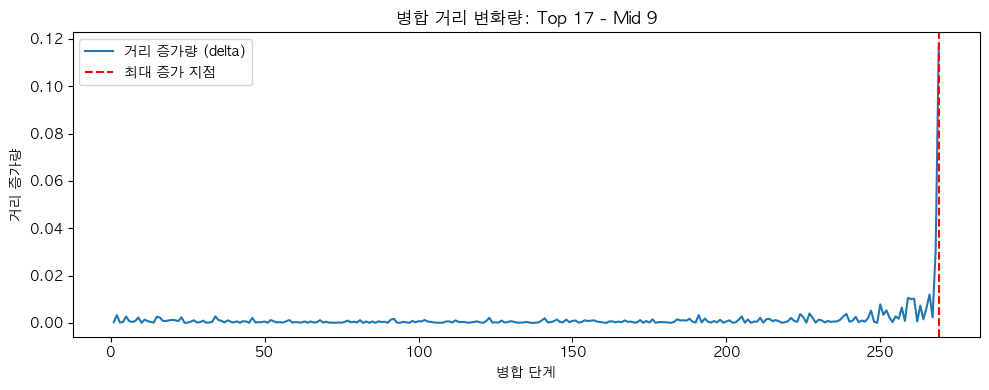

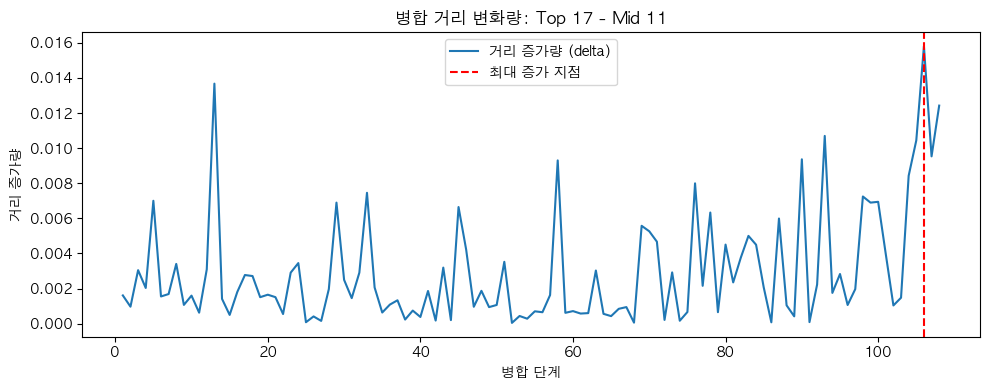

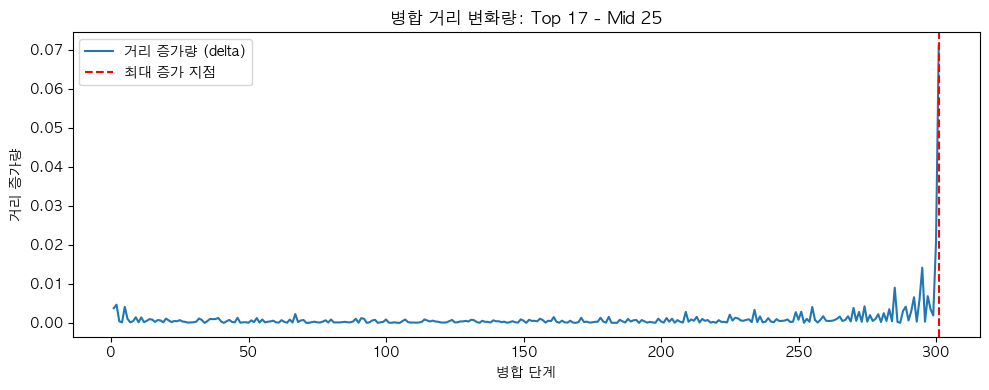

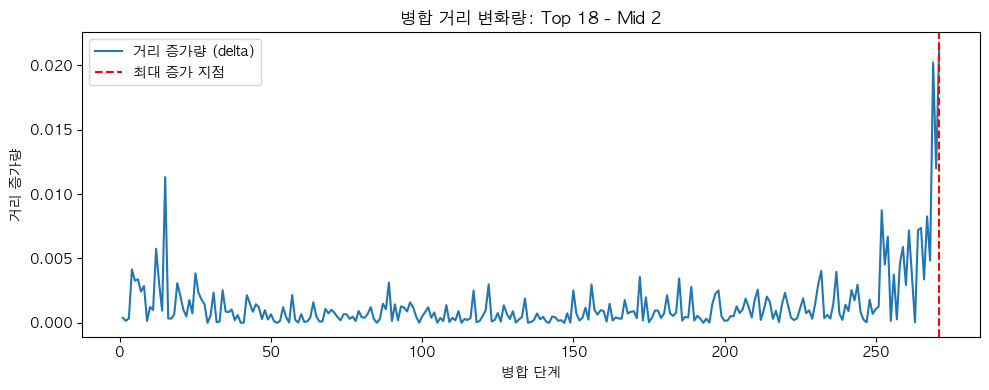

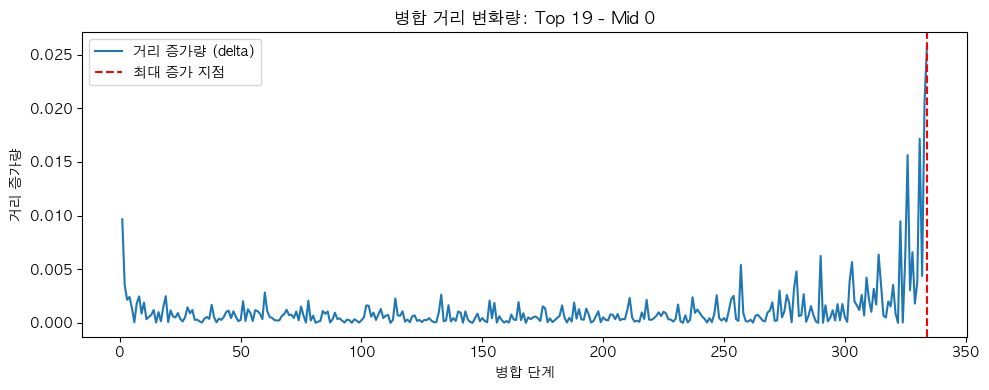

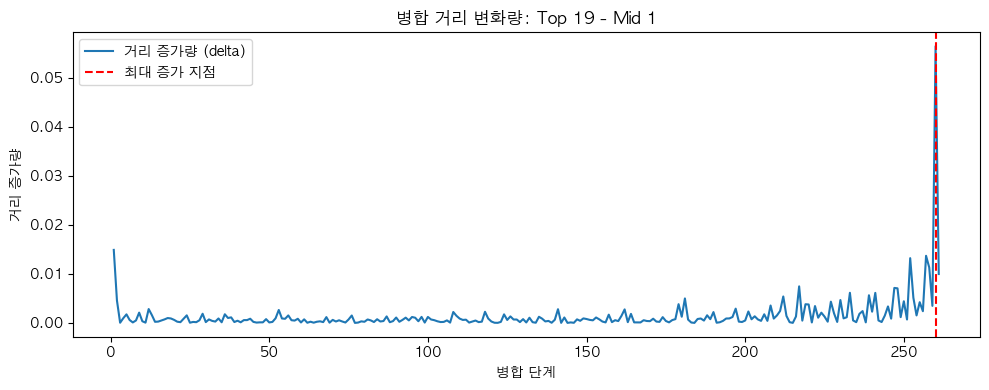

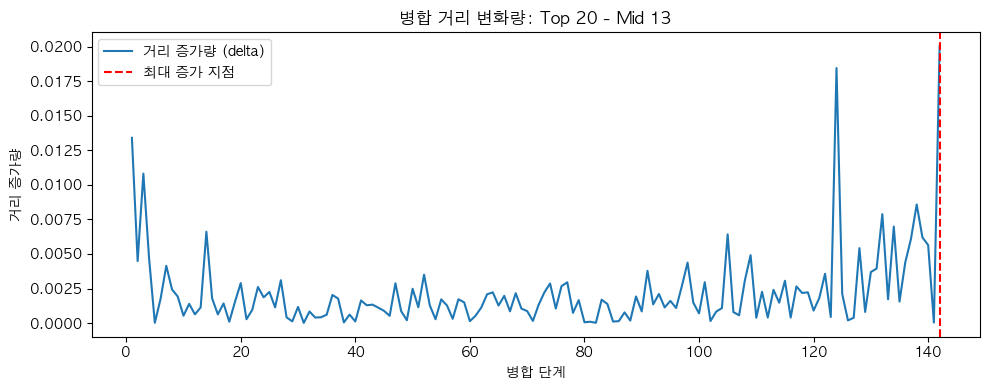

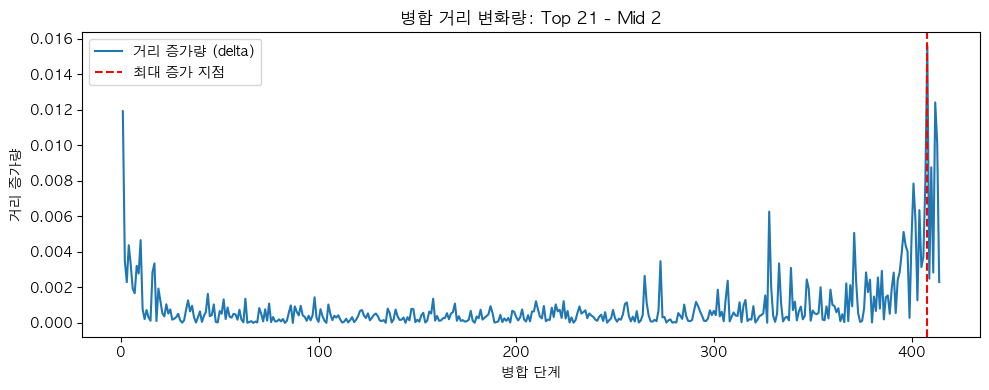

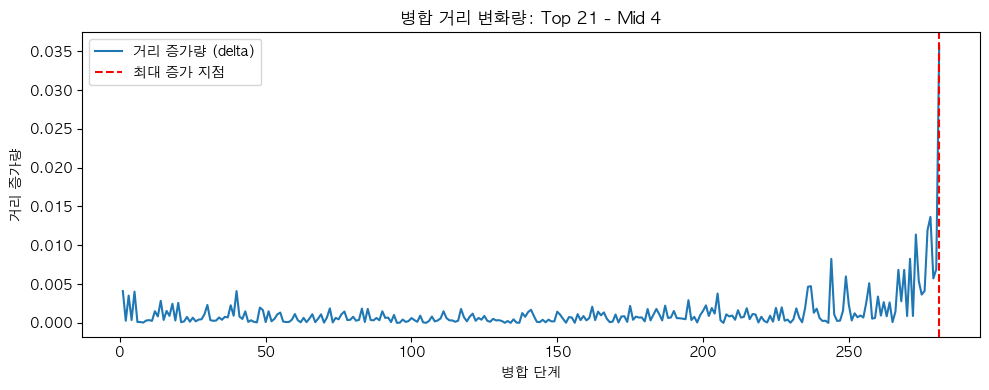

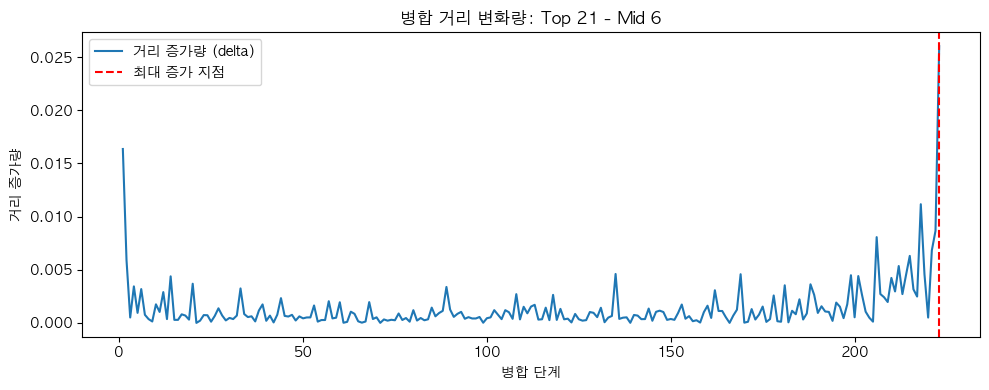

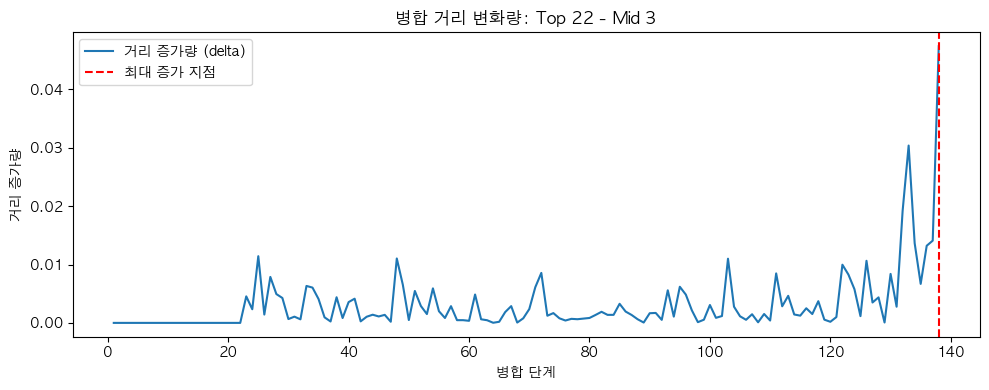

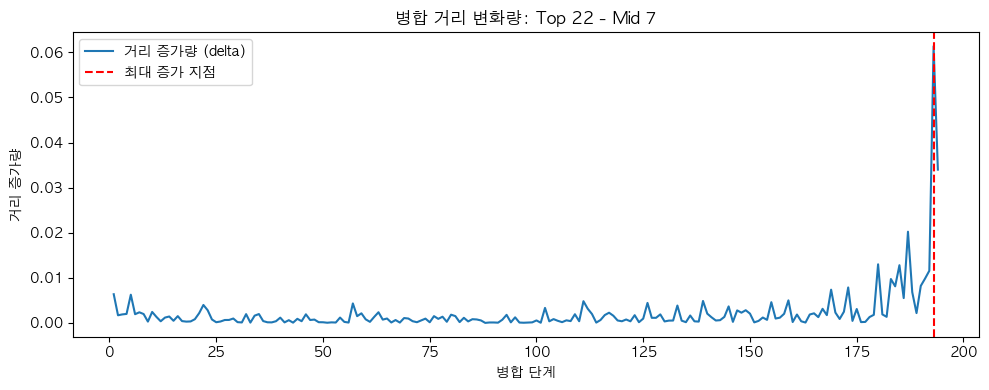

In [29]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import pandas as pd

# 한글 폰트 설정 (macOS 기준)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 결과 저장용 초기화
df['Subcluster'] = 0
sub_keywords_and_texts = {}

# 병합 거리 변화량 시각화 함수
def plot_deltas(deltas, threshold_index, cluster_name):
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(deltas) + 1), deltas, label='거리 증가량 (delta)')
    plt.axvline(x=threshold_index + 1, color='red', linestyle='--', label='최대 증가 지점')
    plt.xlabel("병합 단계")
    plt.ylabel("거리 증가량")
    plt.title(f"병합 거리 변화량: {cluster_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 병합 거리 증가량 및 임계값 계산 함수
def show_linkage_distances(linked):
    distances = linked[:, 2]
    deltas = np.diff(distances)
    threshold_index = np.argmax(deltas)
    threshold_value = distances[threshold_index]

    max_increase_flags = [False] * len(distances)
    if threshold_index + 1 < len(distances):
        max_increase_flags[threshold_index + 1] = True  # delta 최대 줄 (파란색 표시)

    df_merge = pd.DataFrame({
        "병합번호": range(1, len(distances) + 1),
        "병합거리 (distance)": distances,
        "거리 증가량 (delta)": [np.nan] + deltas.tolist(),
        "컷팅 기준 여부 (distance[i])": [i == threshold_index for i in range(len(distances))],
        "delta 최대 여부 (distance[i+1])": max_increase_flags
    })

    return df_merge, threshold_index, threshold_value

# 병합 테이블 Top10 + 색상 강조 출력 함수
def display_top_deltas_with_max(df_merge, threshold_index):
    delta_max_row_index = threshold_index + 1
    distance_cut_row_index = threshold_index

    top_deltas = df_merge.sort_values("거리 증가량 (delta)", ascending=False).head(9)
    delta_max_row = df_merge.iloc[[delta_max_row_index]]
    distance_cut_row = df_merge.iloc[[distance_cut_row_index]]
    merged = pd.concat([top_deltas, delta_max_row, distance_cut_row]).drop_duplicates(subset=["병합번호"])

    def highlight_row(row):
        if row.name == delta_max_row_index:
            return ['background-color: blue'] * len(row)
        elif row.name == distance_cut_row_index:
            return ['background-color: red'] * len(row)
        else:
            return [''] * len(row)

    styled = merged.sort_values("거리 증가량 (delta)", ascending=False).style.apply(highlight_row, axis=1)
    display(styled)

# 벡터 컬럼 정의
vec_cols = list(map(str, range(64)))

# Topcluster → Midcluster 단위 AGNES 수행
for top_id in sorted(df['Topcluster'].unique()):
    top_df = df[df['Topcluster'] == top_id]

    for mid_id in sorted(top_df['Midcluster'].unique()):
        sub_df = top_df[top_df['Midcluster'] == mid_id]
        if len(sub_df) <= 100:
            continue  # 너무 작으면 스킵

        vectors = sub_df[vec_cols].values
        texts = sub_df['generated_summary'].tolist()
        indices = sub_df.index.tolist()

        # linkage 및 임계값 계산
        linked = linkage(vectors, method="average", metric="cosine")
        df_merge, threshold_index, threshold_value = show_linkage_distances(linked)
        deltas = np.diff(linked[:, 2])

        cluster_name = f"Top {top_id} - Mid {mid_id}"
        plot_deltas(deltas, threshold_index, cluster_name=cluster_name)
        display_top_deltas_with_max(df_merge, threshold_index)

        # 덴드로그램 컷팅
        labels = fcluster(linked, t=threshold_value, criterion="distance")
        df.loc[indices, 'Subcluster'] = labels

        # 키워드 추출
        for sub_id in sorted(set(labels)):
            sub_idx = [i for i, l in enumerate(labels) if l == sub_id]
            sub_texts = [texts[i] for i in sub_idx]
            if len(sub_texts) < 3:
                continue

            tfidf = TfidfVectorizer(max_features=30)
            X_tfidf = tfidf.fit_transform(sub_texts)
            tfidf_keywords = tfidf.get_feature_names_out()

            lda = LatentDirichletAllocation(n_components=1, random_state=42)
            lda.fit(X_tfidf)
            lda_keywords = [
                tfidf.get_feature_names_out()[i]
                for i in lda.components_[0].argsort()[-10:][::-1]
            ]

            sub_keywords_and_texts[f"{top_id}-{mid_id}-{sub_id}"] = {
                'TFIDF': tfidf_keywords.tolist(),
                'LDA': lda_keywords
            }

# Subcluster ID 최종 생성
df['Subcluster_ID'] = (
    df['Topcluster'].astype(str) + "_" +
    df['Midcluster'].astype(str) + "_" +
    df['Subcluster'].astype(str)
)

In [30]:
df
# Topcluster, Midcluster, Subcluster 확인 가능

ticket_id_hashed                                  generated_summary  \
0              569aa41  The user suggests having the control panel lig...   
1              d71a6d7  The user suggests allowing full integration wi...   
2              04d7c25  The user suggests improving local control over...   
3              b6452d1  The user suggests enabling remote start withou...   
4              d25d98b  The user suggests providing a way to correct t...   
...                ...                                                ...   
24318          e0d440d  The user suggests changing the connection part...   
24319          45e8080  The user suggests a feature that allows settin...   
24320          864eeff  The user suggests adding an option for up, dow...   
24321          6f042cb  The user suggests saving the wind direction se...   
24322          2ce21ff  The user suggests enabling the ability to set ...   

              0         1         2         3         4         5         6  \
0      0.075767  0.079022  0.016558 -0.162251 -0.069939  0.176784  0.344817   
1     -0.052784  0.040736 -0.131763  0.073862  0.318433 -0.123994 -0.159574   
2     -0.028329  0.013609 -0.059702  0.057278  0.343442 -0.005791 -0.218238   
3     -0.141433 -0.018786  0.016334  0.223997 -0.112966  0.064390 -0.218879   
4     -0.238858  0.078645 -0.262218  0.181303 -0.024056 -0.108034 -0.032344   
...         ...       ...       ...       ...       ...       ...       ...   
24318 -0.024508 -0.128419 -0.170698 -0.195582  0.054395  0.188260 -0.028575   
24319 -0.129325  0.037916 -0.320286  0.107807 -0.081001  0.065715  0.450952   
24320 -0.219595 -0.075191  0.036713 -0.190824 -0.254214  0.116395  0.048776   
24321  0.015032  0.064386 -0.119413 -0.054165 -0.056012  0.143908 -0.008847   
24322 -0.153779 -0.082016 -0.118203 -0.002988  0.111144  0.223693  0.318352   

              7  ...        60        61        62        63  Topcluster  \
0      0.145883  ... -0.197554 -0.010960 -0.001367  0.213566           7   
1     -0.052375  ... -0.277661  0.392118 -0.274975  0.241090           0   
2      0.090118  ... -0.490866  0.327098  0.023757  0.108377           0   
3      0.050858  ... -0.181656  0.142165 -0.291786 -0.186976           6   
4      0.006672  ... -0.378175  0.068542  0.088154  0.020848          12   
...         ...  ...       ...       ...       ...       ...         ...   
24318 -0.063503  ... -0.466052  0.099158  0.047679 -0.176595          13   
24319 -0.097956  ... -0.314283  0.065789 -0.038813  0.204168          14   
24320 -0.096348  ... -0.420390  0.176029  0.159094 -0.157889          13   
24321 -0.081922  ... -0.468905  0.182202  0.119406  0.020134          13   
24322 -0.054892  ... -0.472674  0.043123  0.189785  0.035609          13   

       Silhouette  Midcluster  Midcluster_ID  Subcluster  Subcluster_ID  
0        0.091018           1            7_1          28         7_1_28  
1       -0.008502          27           0_27           0         0_27_0  
2       -0.019235          27           0_27           0         0_27_0  
3        0.106826           5            6_5           2          6_5_2  
4        0.141516           7           12_7           3         12_7_3  
...           ...         ...            ...         ...            ...  
24318    0.020911          17          13_17           0        13_17_0  
24319    0.074073           2           14_2           2         14_2_2  
24320    0.066487          17          13_17           0        13_17_0  
24321    0.037834           4           13_4           1         13_4_1  
24322   -0.020969          20          13_20           3        13_20_3  

[24323 rows x 72 columns]

In [2]:
# 대분류 개수
df['Topcluster'].nunique()

23

In [3]:
# 중분류 개수
df['Midcluster_ID'].nunique()

59

In [4]:
df['Subcluster_ID'].nunique()

125

In [3]:
# Subcluster_ID별 개수 세기
subcluster_counts = df['Subcluster_ID'].value_counts().sort_index()
print(subcluster_counts)

Subcluster_ID
0_0_1       5
0_0_2    1393
0_1_0      29
0_2_0      40
0_3_0       5
         ... 
9_0_0       4
9_1_1      29
9_1_2      27
9_1_3       8
9_1_4    1567
Name: count, Length: 125, dtype: int64


In [34]:
df.to_csv('./all_origin_emb_red_clu_final_2.csv', index=False)

In [1]:
import pandas as pd

df = pd.read_csv('./all_origin_emb_red_clu_final.csv')

## 4. TFIDF & LDA

In [4]:
import os
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk 리소스 다운로드
# nltk.download('punkt')
# nltk.download('stopwords')

### 1. TF-IDF 키워드 추출 함수
def extract_keywords(texts, top_n=5):
    if len(texts) == 0:
        return ["No Keywords"]
    try:
        stop_words = text.ENGLISH_STOP_WORDS
        excluded_words = ['user', 'suggests', 'suggest', 'suggestion']
        stop_words = list(stop_words.union(set(excluded_words)))
        vectorizer = TfidfVectorizer(max_df=0.85, min_df=1, stop_words=stop_words)
        tfidf_matrix = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()
        avg_tfidf = tfidf_matrix.mean(axis=0).A1
        keywords = [feature_names[i] for i in avg_tfidf.argsort()[-top_n:]]
        return keywords
    except ValueError as e:
        print(f"Error while extracting keywords: {e}")
        return ["Error"]

### 2. LDA 토픽 모델링 함수
def preprocess_texts(texts, extra_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if extra_stopwords:
        stop_words = stop_words.union(set(extra_stopwords))

    processed = []
    for text in texts:
        tokens = word_tokenize(text.lower(), preserve_line=True)
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        processed.append(tokens)
    return processed

def cluster_topic_modeling(final_df, cluster_col, text_col, num_topics=1, num_words=5, excluded_words=None):
    clusters = final_df[cluster_col].unique()
    cluster_topics = {}

    for cluster in clusters:
        cluster_texts = final_df[final_df[cluster_col] == cluster][text_col].dropna().tolist()
        cluster_texts = [text for text in cluster_texts if text.strip()]
        processed_texts = preprocess_texts(cluster_texts, extra_stopwords=excluded_words)

        if not processed_texts or all(len(text) == 0 for text in processed_texts):
            cluster_topics[cluster] = ["No topic"]
            continue

        dictionary = corpora.Dictionary(processed_texts)
        corpus = [dictionary.doc2bow(text) for text in processed_texts]

        if len(dictionary.token2id) == 0:
            cluster_topics[cluster] = ["No topic"]
            continue

        lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        topics = lda_model.print_topics(num_words=num_words)
        topic_keywords = [t[1] for t in topics]
        cluster_topics[cluster] = topic_keywords

    return cluster_topics

### 3. TF-IDF + LDA 병합
def merge_keywords_and_topics(tfidf_dict, topic_dict):
    all_clusters = sorted(set(tfidf_dict.keys()).union(set(topic_dict.keys())))
    merged_data = []

    for cluster in all_clusters:
        tfidf_keywords = ', '.join(tfidf_dict.get(cluster, ["No Keywords"]))
        topic_keywords = ', '.join(topic_dict.get(cluster, ["No topic"]))
        merged_data.append((cluster, tfidf_keywords, topic_keywords))

    merged_df = pd.DataFrame(merged_data, columns=["Cluster", "TFIDF_Keywords", "LDA_Topic_Keywords"])
    return merged_df

### 4. 클러스터별 키워드 추출 (TF-IDF 전용)
def get_cluster_keywords(final_df, cluster_col, text_col, top_n=5):
    clusters = final_df[cluster_col].unique()
    cluster_keywords = {}
    for cluster in clusters:
        cluster_texts = final_df[final_df[cluster_col] == cluster][text_col].dropna().tolist()
        cluster_texts = [text for text in cluster_texts if text.strip()]
        keywords = extract_keywords(cluster_texts, top_n)
        cluster_keywords[cluster] = keywords
    return cluster_keywords

### 5. 실행 파이프라인
def run_pipeline(final_df, level_name, cluster_col, text_col):
    print(f"\n▶ Processing: {level_name}")
    tfidf_keywords = get_cluster_keywords(final_df, cluster_col, text_col)
    topic_keywords = cluster_topic_modeling(final_df, cluster_col, text_col, excluded_words=excluded_words)
    merged_df = merge_keywords_and_topics(tfidf_keywords, topic_keywords)

    output_path = f"./all_{level_name}_TFIDF_LDA.csv"
    merged_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"저장 완료: {output_path}")

text_col = 'generated_summary'
excluded_words = ['user', 'suggests', 'suggest', 'suggestion']

### 6. 메인 실행
if __name__ == "__main__":
    # 이미 final_df가 메모리에 존재한다고 가정
    text_col = 'generated_summary'
    excluded_words = ['user', 'suggests', 'suggest', 'suggestion']
    
    # Midcluster / Subcluster 단위 분석 실행
    run_pipeline(df, "Topcluster", "Topcluster", text_col)
    run_pipeline(df, "Midcluster", "Midcluster_ID", text_col)
    run_pipeline(df, "Subcluster", "Subcluster_ID", text_col)

    # 에러발생 이유: texts의 개수가 매우 적은 경우 (예: Subcluster 안에 문서가 1~2개뿐인 경우)
    # 1~2개여도 괜찮다면 좀 더 유하게 조정 or subcluster 자체를 하지말기 등 고민 필요


▶ Processing: Topcluster
저장 완료: ./all_Topcluster_TFIDF_LDA.csv

▶ Processing: Midcluster
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
저장 완료: ./all_Midcluster_TFIDF_LDA.csv

▶ Processing: Subcluster
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to < documents than min_df
Error while extracting keywords: max_df corresponds to <

In [1]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv('./all_origin_updated.csv')
len(df)

24323

In [1]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv('./all_origin_updated.csv')
# 필요한 칼럼만 선택
selected_columns = [
    'ticket_id_hashed', 'components', 'keyword', '지역',
    'beforechange', 'afterchange', 'generated_summary', 'labels'
]
df_selected = df[selected_columns]

# 8000개씩 3개 파일로 자르기
df_selected_1 = df_selected[:8000]
df_selected_2 = df_selected[8000:16000]
df_selected_3 = df_selected[16000:]

df_selected_1.to_csv('./rag_data_1.csv', index=False, encoding='utf-8-sig')
df_selected_2.to_csv('./rag_data_2.csv', index=False, encoding='utf-8-sig')
df_selected_3.to_csv('./rag_data_3.csv', index=False, encoding='utf-8-sig')
df_selected.to_csv('./rag_data.csv', index=False, encoding='utf-8-sig')

In [2]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv('./rag_data.csv')

# 각 그룹별 키워드 세트 (숫자 없이)
group_keywords = {
    '정수기': ['정수기'],
    '에어컨': ['에어컨', 'Air Conditioners'],
    '세탁기/건조기': ['세탁기', 'Washer', '워시타워', '건조기', 'WashTower', '세탁건조기'],
    '청소기': ['로봇청소기', '물걸레로봇청소기', '스틱청소기'],
    '제습기': ['제습기'],
    '가습기': ['가습기'],
    '공기 청정기': ['공기청정기', '에어로타워', '에어로퍼니처', 'AeroTower', 'AirPurifier'],
    '식기세척기': ['식기세척기', 'Dishwasher'],
    '스타일러': ['스타일러'],
    '오븐/레인지': ['Oven', '전기레인지', '광파오븐', 'Over the Range', 'Cooktop', '가스레인지'],
    '기타': ['ThinQ', '기타', '공통', 'Other', 'Common'],
    'TV/프로젝터': ['TV', '시네빔', '프로젝터', 'HE'],
    '기타 가전': ['Dryer', '틔운', '안마의자', '슈케이스', '슈케어', '퓨리케어마스크', '드라이기', '홈브루'],
}

# 제외할 Test 티켓
exclude_list = ['AeroTower, Common']

# 역매핑 딕셔너리 만들기
reverse_map = {}
for group, words in group_keywords.items():
    for w in words:
        reverse_map[w.lower()] = group

def get_group(component):
    if not isinstance(component, str):
        return '미분류'
    comp = component.strip().lower()
    if comp in [e.lower() for e in exclude_list]:
        return None
    return reverse_map.get(comp, '미분류')

df['components_group'] = df['components'].apply(get_group)

# 칼럼 detail 보기
print(df['components_group'].unique())
print(df['components_group'].value_counts())
print(df['components_group'].isnull().sum())  # 미분류 개수 확인

# 파일 저장
df.to_csv('./rag_data_with_group.csv', index=False)

['기타 가전' '기타' '세탁기/건조기' '오븐/레인지' '공기 청정기' '미분류' '정수기' 'TV/프로젝터' '식기세척기'
 '가습기' '청소기' '제습기' '스타일러' '에어컨']
components_group
세탁기/건조기    6425
에어컨        3341
미분류        3205
청소기        2448
정수기        1625
공기 청정기     1624
식기세척기      1225
오븐/레인지     1018
제습기        1010
기타 가전       704
기타          589
스타일러        518
TV/프로젝터     349
가습기         242
Name: count, dtype: int64
0
